In [1]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import networkx as nx
import cvxpy as cp
from collections import Counter, defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import networkx as nx
from tabulate import tabulate

# Build Class and function

In [2]:
class Portfolio:
    def __init__(self, data_csv, start="2000-01-01", end="2024-12-31", price_data=None, returns = None):
        self.data_csv = data_csv
        self.symbols = self.data_csv['Symbol']
        self.sector = self.data_csv['Sector']
        self.start = start
        self.end = end
        self.price_data = price_data
        self.returns = returns
        self.dates = None
        self.C_g = None
        self.D = None
        self.cov_g = None
        self.communities = None
        self.weight = None

    def get_data_yahoo(self, save = False, path = None, no_nan = True):
        self.price_data = yf.download(self.symbols.to_list(), self.start , self.end, auto_adjust=False)['Adj Close']
        if no_nan:
            self.price_data.dropna(axis=1, inplace = True)
        if save:
            if path is None:
                raise ValueError("Path must be specified if save is True.")
            self.price_data.to_csv(path)


    def _evaluate_cov_g(self):
        self.D = np.diag(self.returns.std().values)
        self.cov_g = self.D @ self.C_g @ self.D 
        return self.cov_g
    
    def compute_return(self):
        if self.price_data is None and self.returns is None:
             raise ValueError("Price data not available, download or use a valid dataframe")
        elif self.returns is None:
            self.price_data.dropna(axis = 1, inplace = True)
            self.returns = self.price_data.pct_change().dropna()
        self.symbols =  self.returns.columns.to_list()
        self.dates = pd.to_datetime(self.returns .index)
        self.sector = self.data_csv[self.data_csv['Symbol'].isin(self.returns .columns)]['Sector'].to_list()
        return self.returns 

    def mesoscopic_filter(self):
        if self.returns  is None:
            raise ValueError("No return, please before compute return")
        corr_matrix = self.returns.corr().values
        T, N = self.returns .shape
        eigvals, eigvecs = np.linalg.eigh(corr_matrix)
        Q = T / N 
        lambda_max = (1 + 1 / np.sqrt(Q))**2 
        lambda_1 = eigvals[-1] #isolate the biggest eigenvalue
        sigma2 = 1 - lambda_1 / N
        lambda_max = sigma2 * (1 + 1 / np.sqrt(Q))**2 #Laloux correction
        meso_indices = np.where((eigvals > lambda_max) & (eigvals < lambda_1))[0]
        C_g = np.zeros((N, N))
        for i in meso_indices:
            C_g += eigvals[i] * np.outer(eigvecs[:, i], eigvecs[:, i])
        self.C_g = C_g
        self.cov_g = self._evaluate_cov_g()
        return self.C_g



    @staticmethod   
    def _get_risk_fractions(returns_window):
        T, N = returns_window.shape
        corr = returns_window.corr().values

        eigvals, _ = np.linalg.eigh(corr)
        eigvals = np.sort(eigvals)
        
        Q = T / N
        lambda_1 = eigvals[-1]
        sigma2 = 1 - lambda_1 / N
        lambda_max = sigma2 * (1 + 1 / np.sqrt(Q))**2

        noise = eigvals[eigvals <= lambda_max]
        market = np.array([lambda_1])
        meso = eigvals[(eigvals > lambda_max) & (eigvals < lambda_1)]

        total_risk = np.sum(eigvals)
        
        return {
            "noise": np.sum(noise) / total_risk,
            "market": np.sum(market) / total_risk,
            "meso": np.sum(meso) / total_risk,
        }

    def plot_stability(self, windows_years = 2):

        if self.dates is None:
            raise ValueError("No date available, please run compute_return first")
        windows = []
        start = self.dates[0]

        while start + pd.DateOffset(years = windows_years) < self.dates[-1]:
            end = start + pd.DateOffset(years = windows_years)
            windows.append((start, end))
            start = end
        risks = []

        for start, end in windows:
            returns = np.exp(self.returns ) - 1
            returns.index = pd.to_datetime(returns.index)
            subset = returns[(returns.index >= start) & (returns.index < end)]
            risks.append(self._get_risk_fractions(subset))

        risk_df = pd.DataFrame(risks)
        risk_df['window_start'] = [w[0] for w in windows]
        risk_df.set_index('window_start', inplace=True)
        diffs = risk_df.diff().dropna()
        std_noise = diffs['noise'].std()
        std_market = diffs['market'].std()
        std_meso = diffs['meso'].std()

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(risk_df.index, risk_df['noise'], label='Noise', color = "red", marker = 'o', linestyle = 'dashed')
        ax.plot(risk_df.index, risk_df['market'], label='Systemic', color = "blue", marker = 'o', linestyle = 'dashed')
        ax.plot(risk_df.index, risk_df['meso'], label='Mesoscopic', color = "green", marker = 'o', linestyle = 'dashed')

        
        ax.text(risk_df.index[3], risk_df['noise'].iloc[3], rf'$\sigma_r={std_noise:.3f}$', va='bottom', ha='left', size = 12,bbox=dict(facecolor='white', alpha=0.5))
        ax.text(risk_df.index[3], risk_df['market'].iloc[3], rf'$\sigma_s={std_market:.3f}$', va='bottom', ha='right', size = 12,bbox=dict(facecolor='white', alpha=0.5))
        ax.text(risk_df.index[3], risk_df['meso'].iloc[3], rf'$\sigma_g={std_meso:.3f}$', va='bottom', ha='left', size = 12,bbox=dict(facecolor='white', alpha=0.5))

        ax.set_title('Cumulative Risk Fractions over Time')
        ax.set_ylabel('Fraction of Total Risk')
        ax.set_xlabel('Start of 2-Year Window')
        ax.legend()
        ax.grid(True)
        fig.tight_layout()
        plt.show()

    @staticmethod
    def _commu_to_list(G, communities):
        node_to_comm = {}
        for comm_id, nodes in enumerate(communities):
            for node in nodes:
                node_to_comm[node] = comm_id
        n_assets = len(G.nodes)
        communities = [node_to_comm[i] for i in range(n_assets)]
        return communities

    @staticmethod
    def kmeans_C_g(C_g, n_clusters):
        labels = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(C_g)
        return labels

    @staticmethod
    def DBSCAN_Cg(C_g, returns, eps=0.5, min_samples=5, metric='precomputed'):
        X = (returns @ C_g).T 
        dist = pairwise_distances(X, metric='correlation')
        labels = DBSCAN(eps=0.3, min_samples=3, metric='precomputed').fit_predict(dist)
        return labels
    
    @staticmethod
    def sector_to_label(list_sector):
        # Crea la mappatura settore → numero
        sector_to_number = {sector: i for i, sector in enumerate(set(list_sector))}
        
        # Applica la mappatura
        mapped_sectors = [sector_to_number[sector] for sector in list_sector]
        
        return mapped_sectors

    def community_discover(self, algo = "Louvain", seed = 42, **kwargs):
        if self.C_g is None:
            raise ValueError("No Mesoscopic structure found, please run mesoscopic_filter")
        G = nx.from_numpy_array(self.C_g)
        if algo == "Louvain":
            communities = nx.community.louvain_communities(G, seed=seed, weight='weight')
            self.communities = self._commu_to_list(G, communities)
        elif algo == "Label":
                    communities = list(nx.community.fast_label_propagation_communities(G, weight='weight',seed = seed))
                    self.communities = self._commu_to_list(G, communities)
        elif algo == "Kmean":
                    n_clusters = kwargs.get("n_clusters", 5)
                    self.communities = self.kmeans_C_g(self.C_g, n_clusters)
        elif algo == "DBSCAN":
                    min_samples = kwargs.get("min_samples", 20)
                    eps = kwargs.get("eps", 0.5)
                    metric = kwargs.get("metric", "precomputed")
                    self.communities = self.DBSCAN_Cg(returns = self.returns, C_g = self.C_g, eps = eps, min_samples = min_samples, metric = metric)
        elif algo == "Sector":
             self.communities = self.sector_to_label(self.sector)
        else:
            raise ValueError("Select correct algorithm for community discover")

        
        return self.communities

    def plot_communities_pie(self, title = 'Louvain'):
        if self.communities is None:
            raise ValueError("No communities found, please run community_discover")
        comm2sectors = defaultdict(list)
        for asset_idx, comm_id in enumerate(self.communities):
            comm2sectors[comm_id].append(self.sector[asset_idx])

        sector_labels = sorted(set(self.sector)) 
        colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
        ]
        sector_color_dict = dict(zip(sector_labels, colors))

        n_communities = len(comm2sectors)
        n_cols = min(n_communities, 3)
        n_rows = (n_communities + n_cols - 1) // n_cols

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
        axs = axs.flatten() if n_communities > 1 else [axs]
        num_com = 1
        for i, (comm_id, sectors) in enumerate(comm2sectors.items()):
            
            ax = axs[i]
            count = Counter(sectors)
            sizes = [count.get(s, 0) for s in sector_labels]
            total = sum(sizes)
            sizes = [s / total for s in sizes] if total > 0 else [0] * len(sizes)

            # Explode: separa le fette grandi per leggibilità
            explode = [0.05 if s > 0.15 else 0 for s in sizes]

            wedges, texts, autotexts = ax.pie(
                sizes,
                colors=[sector_color_dict[s] for s in sector_labels],
                startangle=90,
                wedgeprops=dict(edgecolor='white'),
                autopct=lambda p: f'{p:.1f}%' if p > 3 else '',
                pctdistance=0.8,
                labeldistance=1.1,
                explode=explode
            )

            for text in autotexts:
                text.set_fontsize(12)
                text.set_horizontalalignment('center')
                text.set_verticalalignment('center')
                text.set_weight('bold')

            ax.set_title(f"Community {num_com}", fontsize=14)
            num_com += 1
            ax.axis('equal')
            
        fig.suptitle(f"Community Searching Algorithm {title}", fontsize = 14)

        
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

       
        fig.legend(
            handles=[plt.Line2D([0], [0], marker='o', color='w', label=lab,
                                markerfacecolor=sector_color_dict[lab], markersize=10)
                    for lab in sector_labels],
            loc='lower center',
            ncol=min(len(sector_labels), 5),
            bbox_to_anchor=(0.5, -0.05),
            title = 'Sector'
        )
        plt.tight_layout()
        plt.show()

    @staticmethod
    def solve_gmv(cov_g, short = False):
        N = cov_g.shape[0]
        w = cp.Variable(N)
        objective = cp.Minimize(cp.quad_form(w, cov_g))
        if short:
            constraints = [cp.sum(w) == 1]
        else:
            constraints = [cp.sum(w) == 1,  w >= 0 ]
        problem = cp.Problem(objective, constraints)
        problem.solve()
        return w.value

    @staticmethod
    def solve_gmv_community(cov_g, community_labels, short=False):
        N = len(community_labels)
        
        # Ricostruisci: community_id → [asset indices]
        community_map = defaultdict(list)
        for idx, c_id in enumerate(community_labels):
            community_map[c_id].append(idx)

        community_list = list(community_map.values())
        n = len(community_list)

        Sigma_c = np.zeros((n, n))

        for c in range(n):
            assets_c = community_list[c]
            Nc = len(assets_c)

            var_c = np.mean([cov_g[i, i] for i in assets_c])
            cov_c = np.mean([cov_g[i, j] for i in assets_c for j in assets_c if i != j]) if Nc > 1 else 0
            Sigma_c[c, c] = var_c + (Nc - 1) * cov_c

            for k in range(c + 1, n):
                assets_k = community_list[k]
                cross_cov = np.mean([cov_g[i, j] for i in assets_c for j in assets_k])
                Sigma_c[c, k] = Sigma_c[k, c] = cross_cov

        W = cp.Variable(n)
        objective = cp.Minimize(cp.quad_form(W, Sigma_c))
        if short:
            constraints = [cp.sum(W) == 1]
        else:
            constraints = [cp.sum(W) == 1,  W >= 0 ]
        prob = cp.Problem(objective, constraints)
        prob.solve()

        weights = np.zeros(N)
        for c, Wc in enumerate(W.value):
            assets_c = community_list[c]
            Nc = len(assets_c)
            for i in assets_c:
                weights[i] = Wc / Nc

        return weights

    def portfolio_building(self, seed = 42,**kwargs ):
        use_community = kwargs.get("community", True)
        is_equal = kwargs.get("is_equal", False)
        if is_equal and use_community:
             raise ValueError("use_community and is_equal cannot be True at same time ")
        short = kwargs.get("short", False)
        algo = kwargs.get("algo", "Louvain")
        seed = kwargs.get("seed", 42)
        min_samples = kwargs.get("min_samples", 5)
        eps = kwargs.get("eps", 0.5)
        metric = kwargs.get("metric", "precomputed")
        self.compute_return()
        if use_community:
            self.mesoscopic_filter()
            algo = kwargs.pop("algo", "Louvain")
            self.communities = self.community_discover(algo = algo, seed = seed, **kwargs)
            self.w = self.solve_gmv_community(self.cov_g,self.communities, short = short)
        elif is_equal:
             self.w = np.ones(len(self.returns.columns)) * 1 / len(self.returns.columns)
        else:
            self.cov_g = self.returns.cov().values 
            self.w = self.solve_gmv(self.cov_g, short)
        return self.w

## Collect and Download Data

In [3]:
data_csv = pd.read_csv('data/SandP500.csv')
data_csv.sort_values(by='Symbol', inplace = True)

### Download (If you already have dataset, you can skip it)

In [4]:
portfolio = Portfolio(data_csv)
portfolio.get_data_yahoo(save = True, path = "data\\price_data.csv", no_nan = True)

[*********************100%***********************]  496 of 496 completed

101 Failed downloads:
['KORS', 'WAG', 'WYN', 'STJ', 'ZMH', 'KRFT', 'MNK', 'MWV', 'ARG', 'MJN', 'GGP', 'FDO', 'SNI', 'NLSN', 'WLP', 'TWC', 'BRCM', 'DPS', 'SPLS', 'SIAL', 'HSP', 'POM', 'WFM', 'LLTC', 'LUK', 'CFN', 'CBG', 'SWY', 'CVC', 'BCR', 'GMCR', 'RAI', 'TSO', 'COG', 'COH', 'CAM', 'HCN', 'PCLN', 'HCBK', 'MHFI', 'LO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2024-12-31)')
['APC', 'XLNX', 'DNR', 'TMK', 'AGN', 'RHT', 'DO', 'FLIR', 'PXD', 'PBCT', 'CTXS', 'MYL', 'ESV', 'NBL', 'KSU', 'QEP', 'VIAB', 'VAR', 'YHOO', 'JEC', 'BBT', 'SWN', 'BLL', 'ETFC', 'SYMC', 'XEC', 'XL', 'LM', 'DTV', 'BBBY', 'TIF', 'UTX', 'DLPH', 'AVP', 'PKI', 'MRO', 'ADS', 'CERN', 'HCP', 'ALXN', 'HRS', 'TSS', 'PDCO', 'WIN', 'ALTR', 'CBS', 'MON', 'GPS', 'DISCA', 'CELG', 'CHK', 'LLL', 'RTN', 'CTL', 'DFS', 'FISV', 'ABC', 'FTR']: YFTzMissingError('possibly delisted; no timezone found')
['SNDK', 'FB']: YFPricesMissing

### Prepare the Dataset

In [4]:
price_data =  pd.read_csv('data/price_data.csv', index_col=0)
portfolio = Portfolio(data_csv, price_data = price_data)
portfolio.compute_return()

A        AA      AAPL       ABT      ADBE       ADI  \
Date                                                                     
2000-01-04 -0.076389  0.004633 -0.084310 -0.028572 -0.083889 -0.050589   
2000-01-05 -0.062030  0.057647  0.014633 -0.001838  0.019771  0.014599   
2000-01-06 -0.038076 -0.013081 -0.086538  0.034990  0.008163 -0.027339   
2000-01-07  0.083334 -0.002946  0.047369  0.010676  0.048583  0.028108   
2000-01-10  0.060577 -0.002954 -0.017588 -0.007042  0.038610  0.087050   
...              ...       ...       ...       ...       ...       ...   
2024-12-23  0.000669  0.019556  0.003065  0.000700 -0.000962  0.014685   
2024-12-24  0.011144  0.000778  0.011478  0.003937  0.002686  0.014891   
2024-12-26 -0.001984 -0.006734  0.003176  0.004444  0.004956 -0.000138   
2024-12-27 -0.002135 -0.017471 -0.013242 -0.002429 -0.008175 -0.004907   
2024-12-30 -0.008263 -0.014066 -0.013263 -0.019045 -0.001523 -0.020416   

                 ADM       ADP      ADSK       AEE  ...        WM       WMB  \
Date                                                ...                       
2000-01-04 -0.010416  0.000000 -0.048689  0.000000  ... -0.003597 -0.022177   
2000-01-05 -0.015790 -0.009615 -0.062992  0.038685  ...  0.003610  0.061855   
2000-01-06  0.005347  0.013349 -0.060924 -0.003725  ... -0.007194  0.021360   
2000-01-07  0.015958  0.022755  0.118568  0.014953  ... -0.039855  0.026616   
2000-01-10  0.000000  0.024590 -0.010099 -0.007366  ...  0.003774 -0.018518   
...              ...       ...       ...       ...  ...       ...       ...   
2024-12-23 -0.001585  0.000442 -0.002113  0.004480  ... -0.009862  0.010469   
2024-12-24  0.004364  0.007853  0.012572  0.013379  ...  0.007753  0.010176   
2024-12-26 -0.000395  0.002597 -0.003154 -0.002200  ... -0.001753 -0.011722   
2024-12-27 -0.000593 -0.003533 -0.008958 -0.006285  ... -0.004877 -0.000371   
2024-12-30 -0.010083 -0.010838 -0.000202 -0.005548  ... -0.008578  0.004079   

                 WMT        WY       XEL       XOM      XRAY       XRX  \
Date                                                                     
2000-01-04 -0.037418 -0.037567  0.023027 -0.019154  0.000000 -0.046511   
2000-01-05 -0.020408  0.052974  0.038585  0.054516  0.017287  0.051490   
2000-01-06  0.010912  0.046779 -0.009288  0.051698  0.001307 -0.020619   
2000-01-07  0.075565 -0.032884  0.000000 -0.002935 -0.002611  0.023685   
2000-01-10 -0.018248 -0.004359  0.000000 -0.013981  0.023560 -0.023137   
...              ...       ...       ...       ...       ...       ...   
2024-12-23 -0.020490  0.021091  0.004748  0.004062  0.013369  0.126341   
2024-12-24  0.025789  0.006410  0.007236  0.000941 -0.002639 -0.023281   
2024-12-26  0.001187 -0.003185 -0.000440  0.000846  0.013757 -0.006500   
2024-12-27 -0.012178 -0.006390 -0.000587 -0.000094 -0.003158 -0.002181   
2024-12-30 -0.011892 -0.003573 -0.008072 -0.006762 -0.015311 -0.026229   

                 YUM      ZION  
Date                            
2000-01-04 -0.020099 -0.048423  
2000-01-05  0.005127 -0.001184  
2000-01-06 -0.008503  0.014219  
2000-01-07 -0.022298  0.002336  
2000-01-10  0.040350 -0.018066  
...              ...       ...  
2024-12-23  0.011333  0.013229  
2024-12-24  0.008516  0.010850  
2024-12-26  0.007407  0.006913  
2024-12-27 -0.005662 -0.012105  
2024-12-30 -0.012645 -0.006584  

[6287 rows x 308 columns]

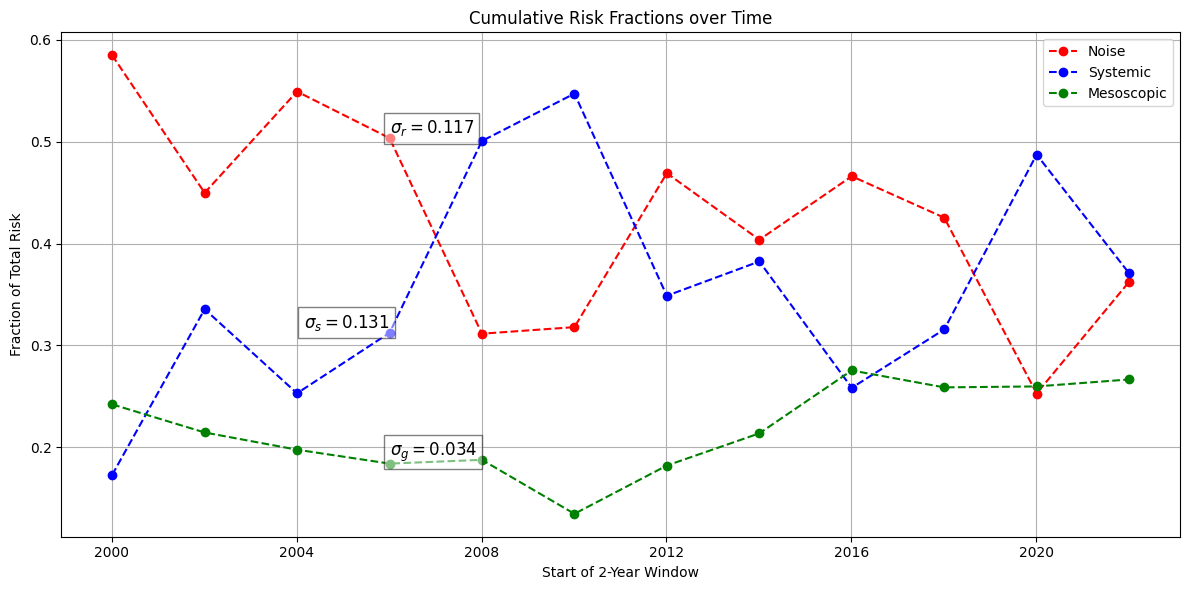

In [5]:
portfolio.plot_stability()

## Community

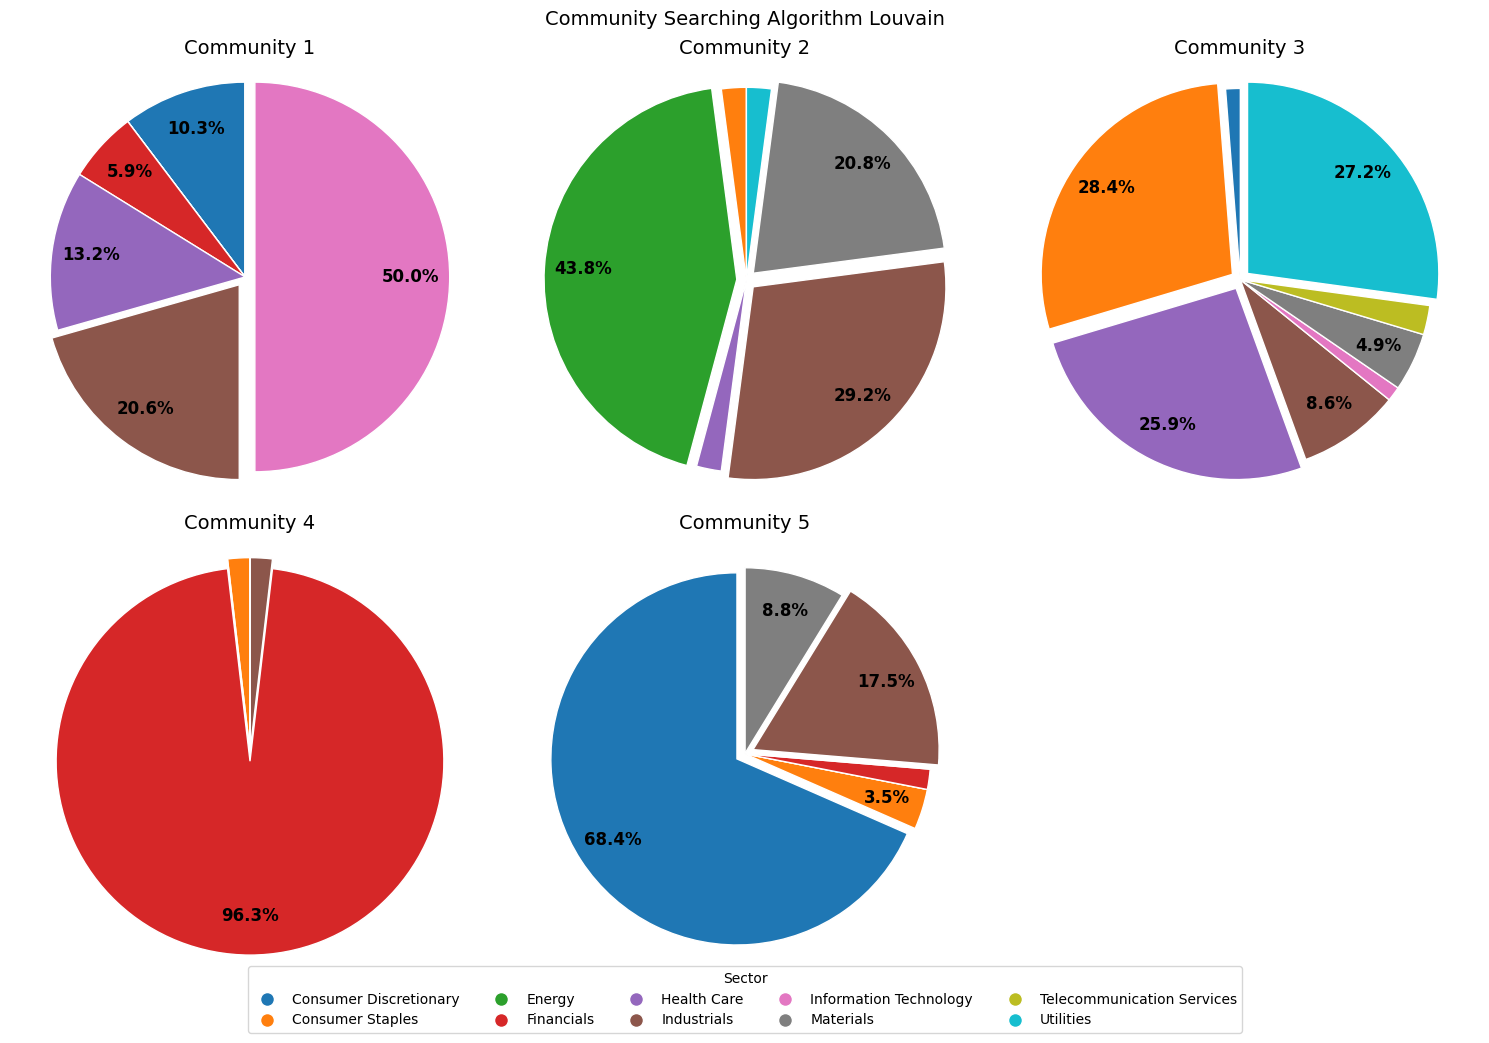

In [6]:
portfolio.mesoscopic_filter()
portfolio.community_discover(algo = "Louvain")
portfolio.plot_communities_pie(title = "Louvain")

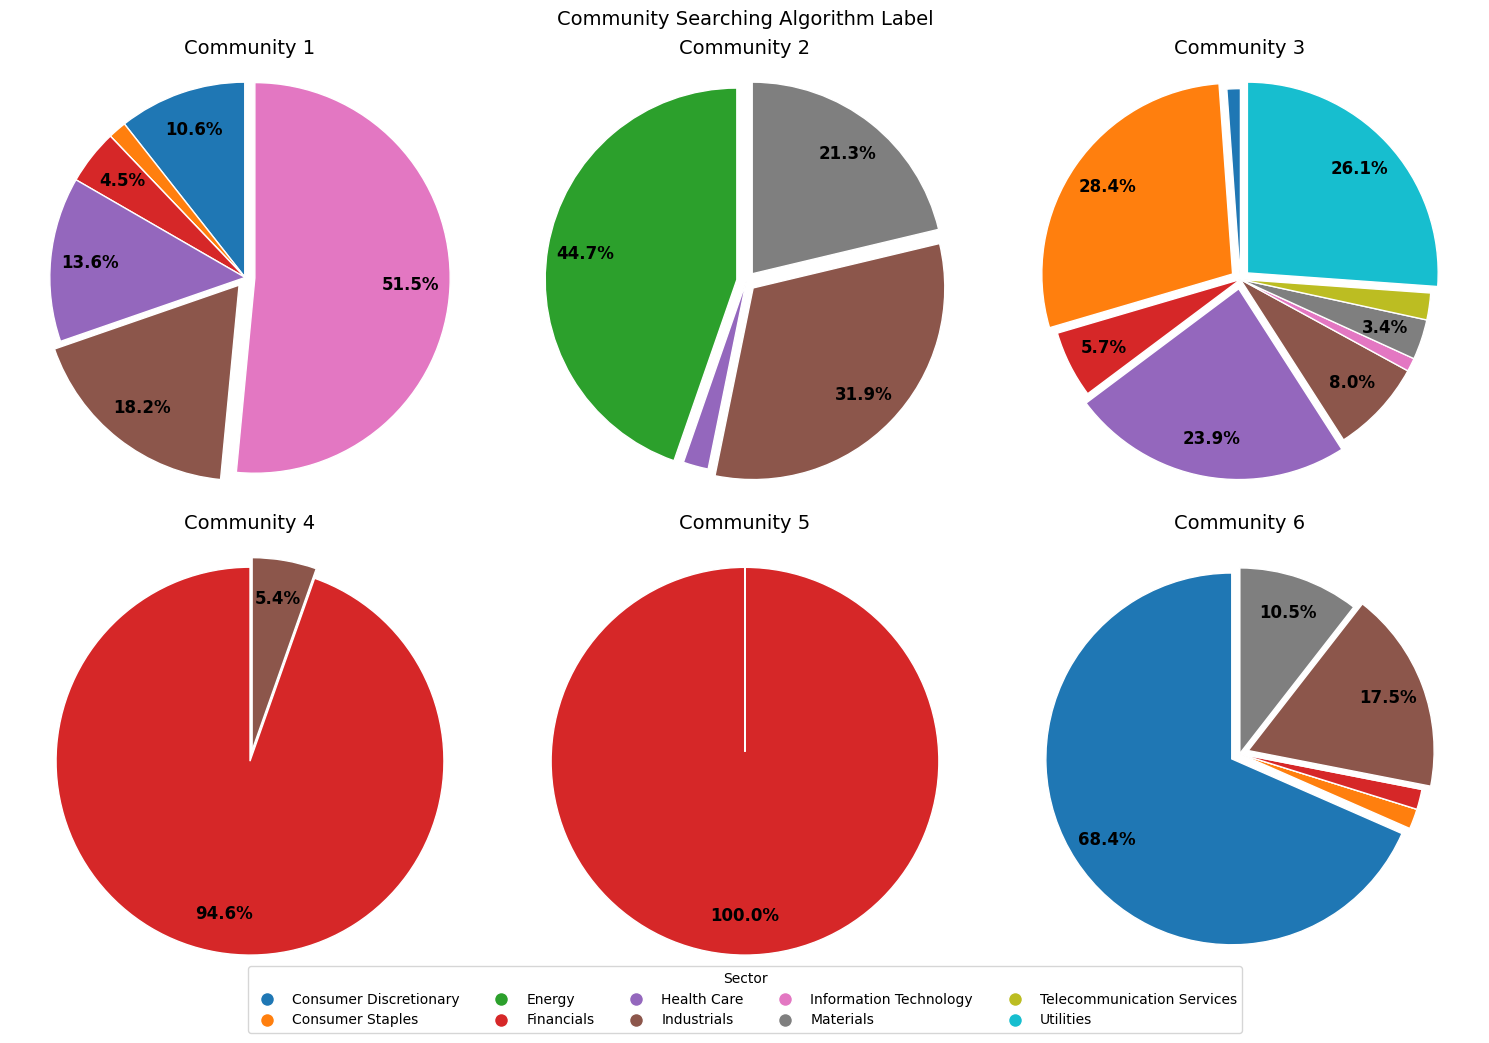

In [7]:
portfolio.mesoscopic_filter()
portfolio.community_discover(algo = "Label")
portfolio.plot_communities_pie(title = 'Label')

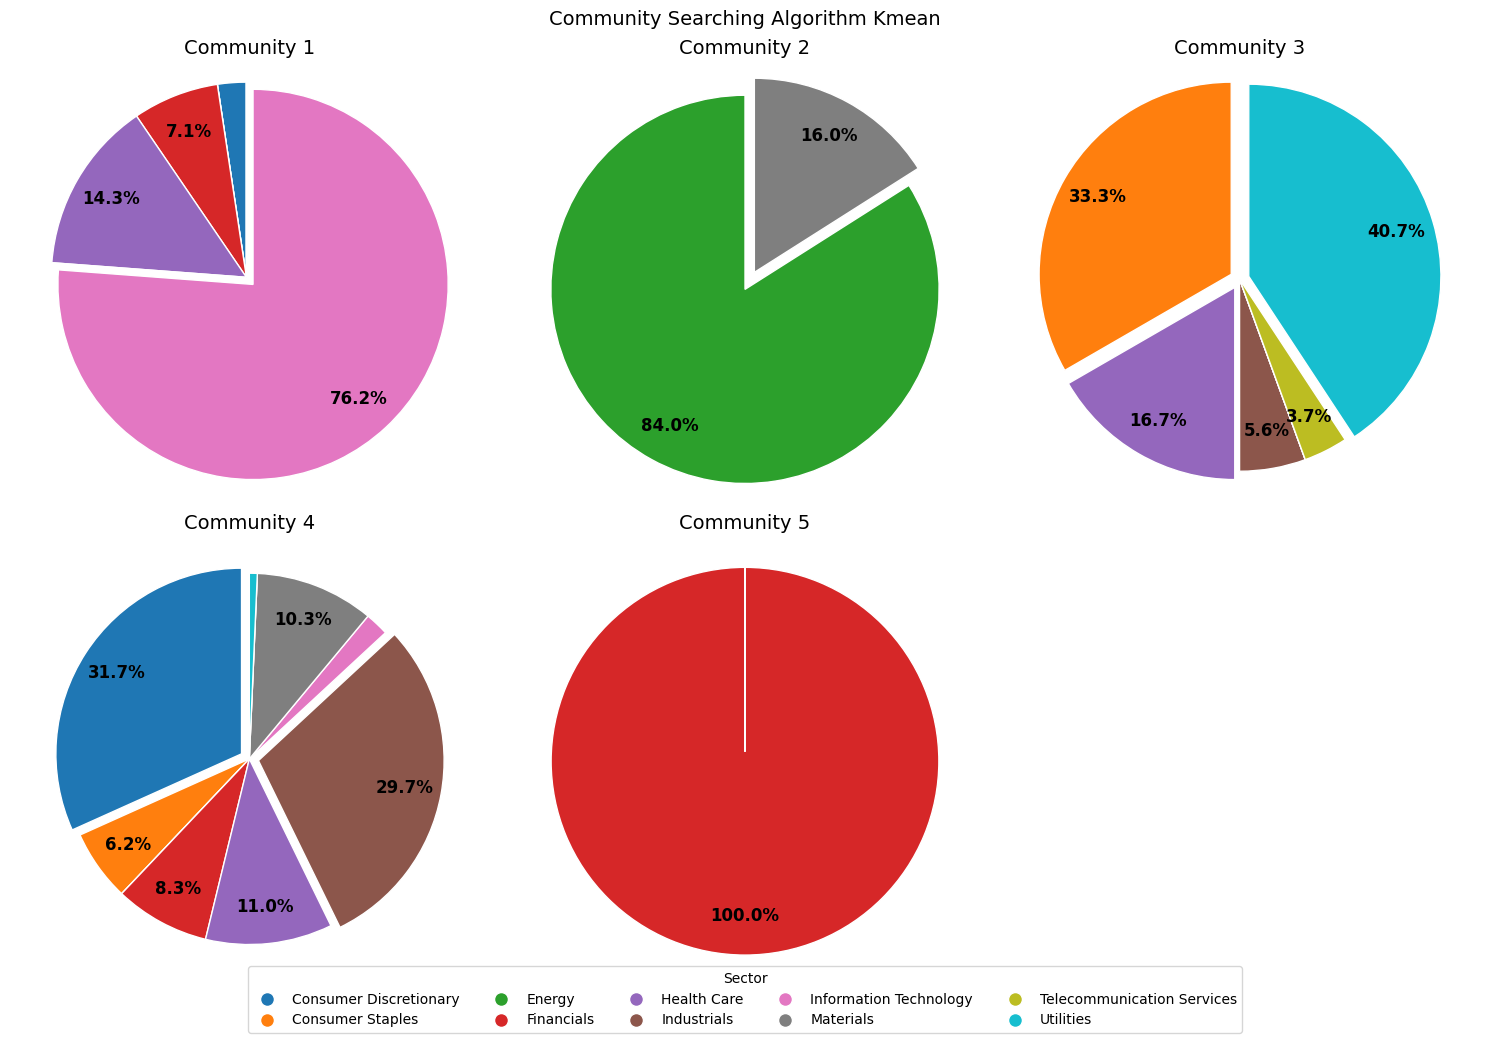

In [8]:
portfolio.mesoscopic_filter()
portfolio.community_discover(algo = "Kmean")
portfolio.plot_communities_pie(title = 'Kmean')

## Portfolio Building

### Weight Distribution asset

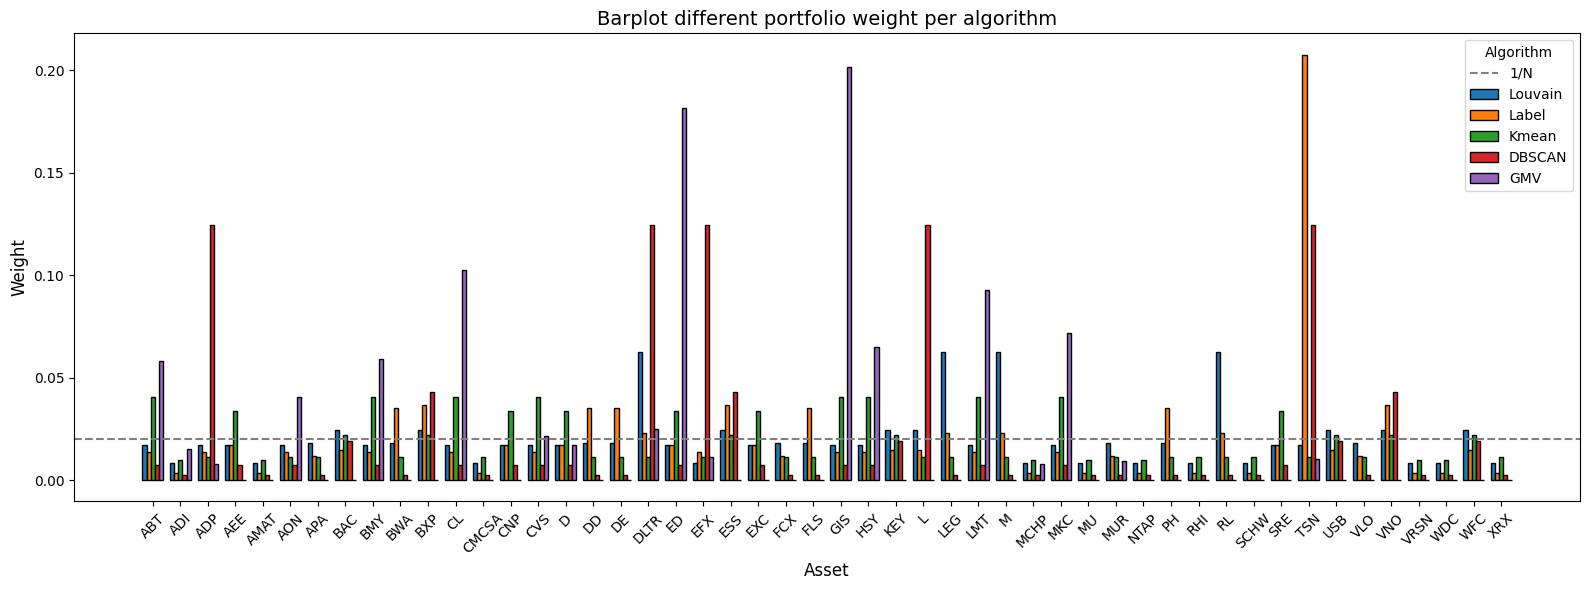

In [20]:
num_asset = 50
price_data_sampled = price_data.sample(n= num_asset, axis=1, random_state=42)
price_data_sampled = price_data_sampled[sorted(price_data_sampled.columns)]
returns = price_data_sampled.pct_change().dropna() 
portfolio = Portfolio(data_csv, price_data = price_data_sampled, returns = returns)
portfolio.C_g = portfolio.mesoscopic_filter()
weights_dict = {}

#alg_list = ["Louvain", "Label", "Kmean", "DBSCAN", "GMV"]
alg_list = ["Louvain", "Label", "Kmean", "DBSCAN"]
for alg in alg_list: 
    communities = portfolio.community_discover(algo=alg)
    weights = portfolio.portfolio_building(community=True, algo=alg)
    weights_dict[alg] = weights

weights_dict['GMV'] = portfolio.portfolio_building(community=False)
weights_df = pd.DataFrame(weights_dict, index=price_data_sampled.columns)

# Plot
labels = weights_df.index.to_list()           
algorithms = weights_df.columns.to_list()     
n_algos = len(algorithms)
x = np.arange(len(labels))                    
width = 0.15                                  

fig, ax = plt.subplots(figsize=(16, 6))
for i, algo in enumerate(algorithms):
    bar_positions = x + (i - n_algos/2) * width + width/2
    ax.bar(bar_positions, weights_df[algo], width=width, label=algo, edgecolor='black')

ax.axhline(1/num_asset, color='gray', linestyle='--', linewidth=1.5, label='1/N')
ax.set_title("Barplot different portfolio weight per algorithm", fontsize=14)
ax.set_ylabel("Weight", fontsize=12)
ax.set_xlabel("Asset", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(title="Algorithm")
plt.tight_layout()
plt.show()

## Back-test

In [10]:
def fine_tuning_k_means(portfolio_train,split = 0.8, list_cluster = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], short = False, verbose = True):
    train_size = int(len(portfolio_train.returns) * split)
    train_df = portfolio_train.returns.iloc[:train_size]
    val_df = portfolio_train.returns.iloc[train_size:].values
    sharp_ratio = []
    for cluster in list_cluster:
        portfolio_train = Portfolio(data_csv, price_data = portfolio_train.price_data, returns = train_df)
        weights = portfolio_train.portfolio_building(short = short, community = True, algo = 'Kmean', n_clusters = cluster)
        test_returns = val_df @ weights
        sharpe_ann = test_returns.mean() / test_returns.std() * np.sqrt(252)
        sharp_ratio.append(sharpe_ann)
        if verbose:
            summary_df = pd.DataFrame([
            {
                "Number Cluster": cluster,
                "Sharp Ratio": sharpe_ann,
            }
        ])
        print(tabulate(summary_df.round(4), headers='keys', tablefmt='fancy_grid'))
    print(f"====== Number Cluster: {list_cluster[np.argmax(sharp_ratio)]}======")
    return list_cluster[np.argmax(sharp_ratio)]     

In [11]:
def backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = 'Louvain', short = False, verbose = True, **kwargs):
    returns = portfolio.compute_return()
    returns.index = pd.to_datetime(returns.index)
    results = []
    start_idx = returns.index[0]
    current_date = start_idx
    while current_date + pd.DateOffset(months=train_months + burn_period_month + test_months) < returns.index[-1]:
        train_end = current_date + pd.DateOffset(months=train_months)
        test_start = train_end + pd.DateOffset(months= test_months + burn_period_month)
        test_end = test_start + pd.DateOffset(months=test_months)
        returns_train = returns[(returns.index >= current_date) & (returns.index < train_end)]
        test_data = returns[(returns.index >= test_start) & (returns.index < test_end)]
        portfolio_train = Portfolio(portfolio.data_csv, price_data = portfolio.price_data, returns = returns_train)
        if model == 'Louvain':
            weights = portfolio_train.portfolio_building(short = short, algo = 'Louvain')
            print(f"Cluster found: {len(np.unique(weights))}")
            num_cluster = len(np.unique(weights))
        elif model == 'Label':
            weights = portfolio_train.portfolio_building(short = short, algo = 'Label')
            print(f"Cluster found: {len(np.unique(weights))}")
            num_cluster = len(np.unique(weights))
        elif model == 'Equal':
            weights = np.ones(len(test_data.columns)) * 1 / len(test_data.columns)
            num_cluster = None
        elif model == "GMV":
            weights = portfolio_train.portfolio_building(short = short, community = short)
            num_cluster = None
        elif model == "Kmean":
            fine_tuning = kwargs.get('fine_tuning', False)
            if fine_tuning is True:
                list_cluster = kwargs.get('list_cluster', [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
                num_cluster = fine_tuning_k_means(portfolio_train = portfolio_train,split = 0.8, list_cluster = list_cluster , short = short)
                weights = portfolio_train.portfolio_building(short = short, community = True, algo = 'Kmean', n_cluster = num_cluster)
                print(f"Cluster found: {num_cluster}")
            else:
                weights = portfolio_train.portfolio_building(short = short, community = True, algo = 'Kmean')
                print(f"Cluster found: {len(np.unique(weights))}")
                num_cluster = len(np.unique(weights))
        elif model == "DBSCAN":
            weights = portfolio_train.portfolio_building(short = short, community = True, algo = 'DBSCAN')
            print(f"Cluster found: {len(np.unique(weights))}")
            num_cluster = len(np.unique(weights))
        elif model == "Sector":
            weights = portfolio_train.portfolio_building(short = short, community = True, algo = 'Sector')
            print(f"Cluster found: {len(np.unique(weights))}")
            num_cluster = len(np.unique(weights))
        else:
            raise ValueError("Select a model between (Louvain, Label, Equal, GMV, Kmean, DBASCAN, Sector)")
        test_returns = test_data @ weights
        sigma_p = (portfolio_train.returns@ weights).std()
        sharpe_ann = test_returns.mean() / test_returns.std() * np.sqrt(252)
        sigma_p_ann = sigma_p * np.sqrt(252)
        sigma_test_ann = test_returns.std() * np.sqrt(252)
        results.append({
            "start": train_end,
            "end": test_end,
            "Reliability": np.abs(sigma_test_ann - sigma_p_ann)/sigma_p_ann,
            "Sharpe Ratio": sharpe_ann,
            "Number of Cluster": num_cluster
            })
        if verbose:
            print(results[-1])
        current_date = current_date + pd.DateOffset(months = train_months)
    return results

In [17]:
def plot_results_backtest(results, method_labels, markers,colors):
    dfs = {model: pd.DataFrame(data) for model, data in results.items()}

    for metric in ['Sharpe Ratio', 'Reliability', 'Number of Cluster']:
        fig, ax = plt.subplots(figsize=(16, 8))
        for model, df in dfs.items():
            ax.plot(
                df['end'], df[metric],
                marker=markers[model],
                linestyle='-.',
                color=colors[model],
                label=method_labels[model]
            )

        ax.set_xticks(dfs["Louvain"]['end'])
        ax.set_xticklabels(dfs["Louvain"]['end'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')
        ax.set_title(f"{metric} Comparison Test")
        ax.set_xlabel("End Test Date", size = 12)
        ax.set_ylabel(f"Annualized - {metric}", size = 12)
        ax.grid()
        ax.legend(title = 'Algorithm')
        plt.tight_layout()
        plt.show()

    # Summary Table
    summary_df = pd.DataFrame([
        {
            "Method": method_labels[model],
            "Average Sharpe Ratio ": dfs[model]['Sharpe Ratio'].mean(),
            "Average Reliability": dfs[model]['Reliability'].mean(),
            "Average Number of Cluster": dfs[model]['Number of Cluster'].mean()
        }
        for model in dfs
    ])

    print(tabulate(summary_df.round(4), headers='keys', tablefmt='fancy_grid'))
    return summary_df

====== Start Louvain ======
Cluster found: 5
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.009389617244657922), 'Sharpe Ratio': np.float64(1.5800360667641193), 'Number of Cluster': 5}
Cluster found: 5
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.469176888270495), 'Sharpe Ratio': np.float64(-0.12272316757810023), 'Number of Cluster': 5}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.1937594918617287), 'Sharpe Ratio': np.float64(0.6277783920293531), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5186434662705658), 'Sharpe Ratio': np.float64(0.8960912849893), 'Number of Cluster': 4}
Cluster found: 5
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-07-0

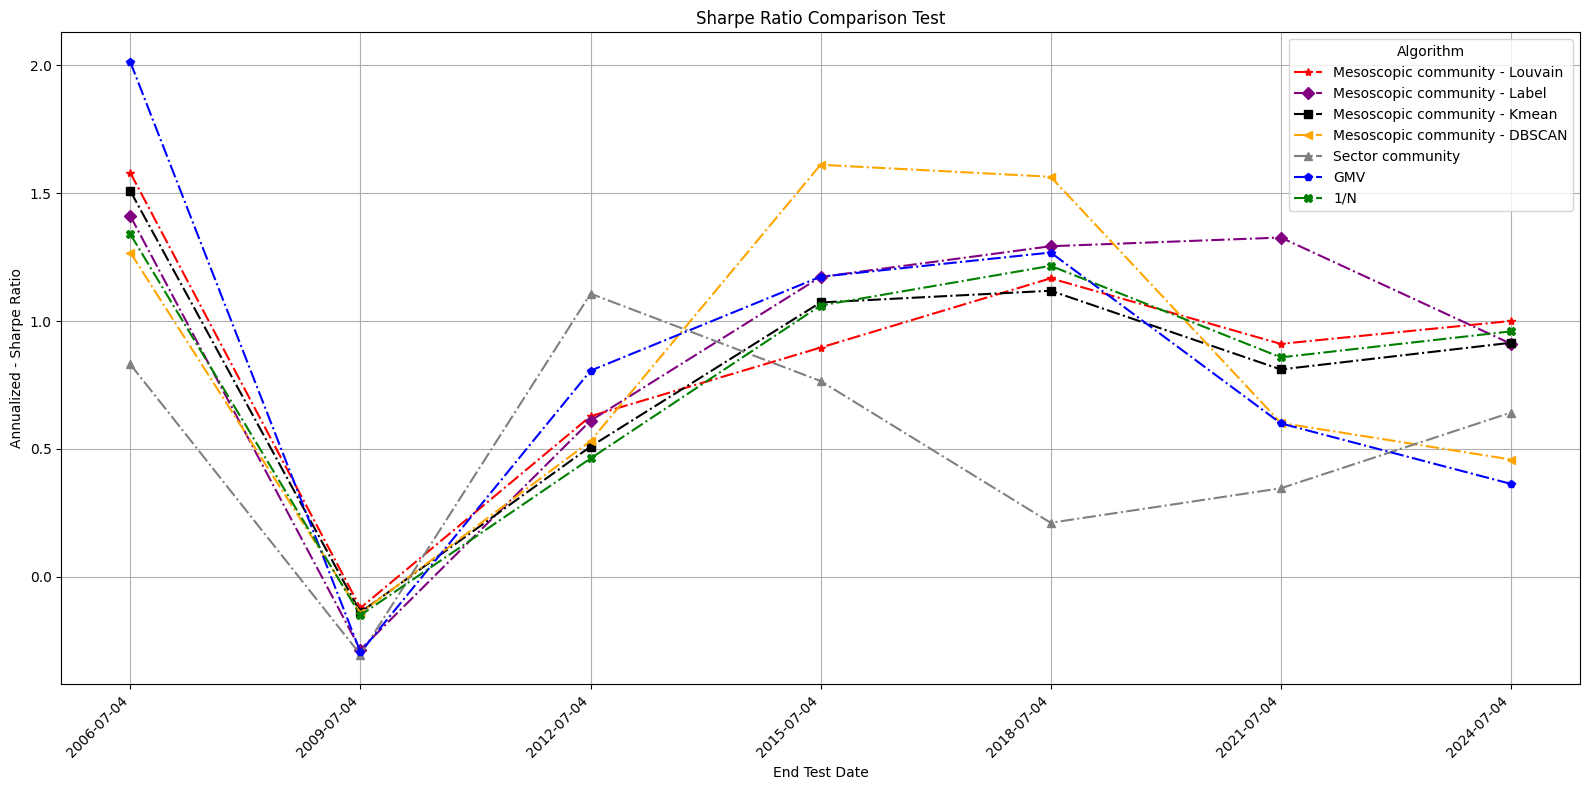

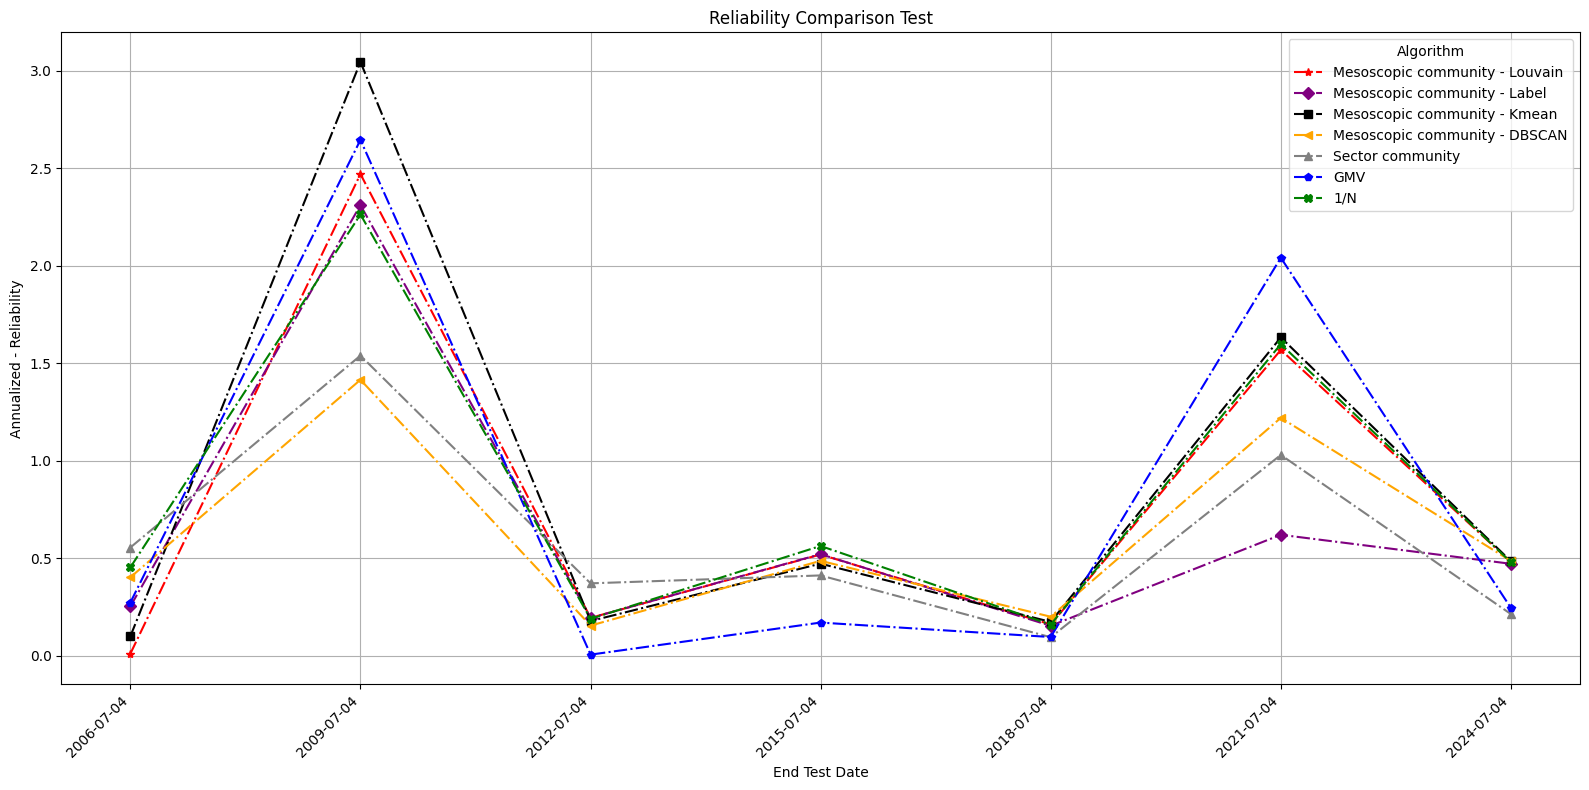

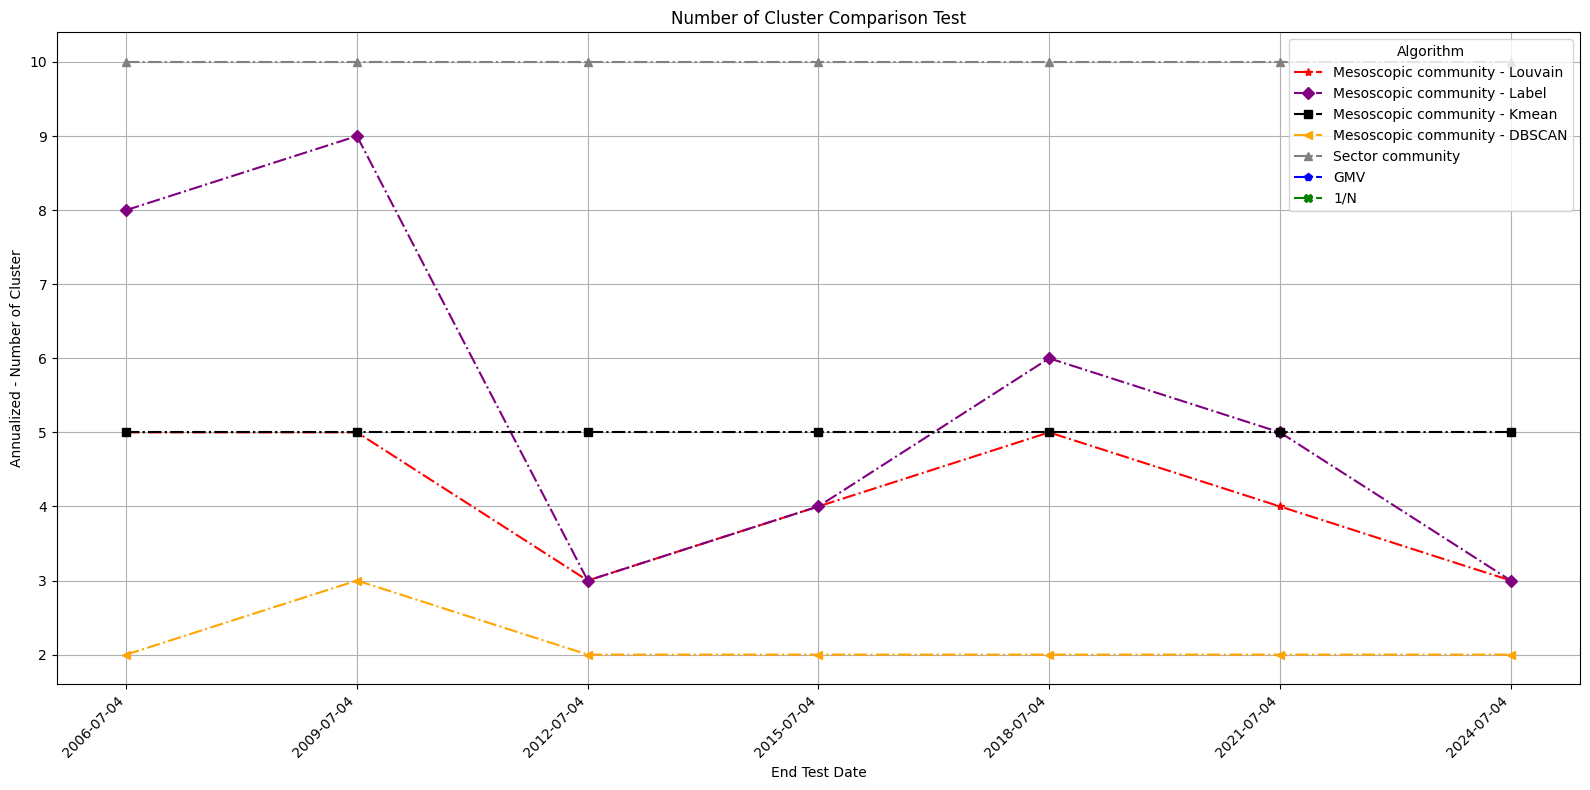

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.8656 │                0.7712 │                      4.1429 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9198 │                0.6456 │                      5.4286 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.8278 │                0.8686 │                      5      │
├────┼────────────────────────────────┼─

In [13]:
model = ["Louvain", "Label", "Kmean", "DBSCAN", "Sector","GMV", "Equal"]
results = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = False, verbose = True)

method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df = plot_results_backtest(results, method_labels, markers, colors)

====== Start Louvain ======
Cluster found: 5
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.009389617244657922), 'Sharpe Ratio': np.float64(1.5800360667641193), 'Number of Cluster': 5}
Cluster found: 5
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.469176888270495), 'Sharpe Ratio': np.float64(-0.12272316757810023), 'Number of Cluster': 5}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.1937594918617287), 'Sharpe Ratio': np.float64(0.6277783920293531), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5186434662705658), 'Sharpe Ratio': np.float64(0.8960912849893), 'Number of Cluster': 4}
Cluster found: 5
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-07-0

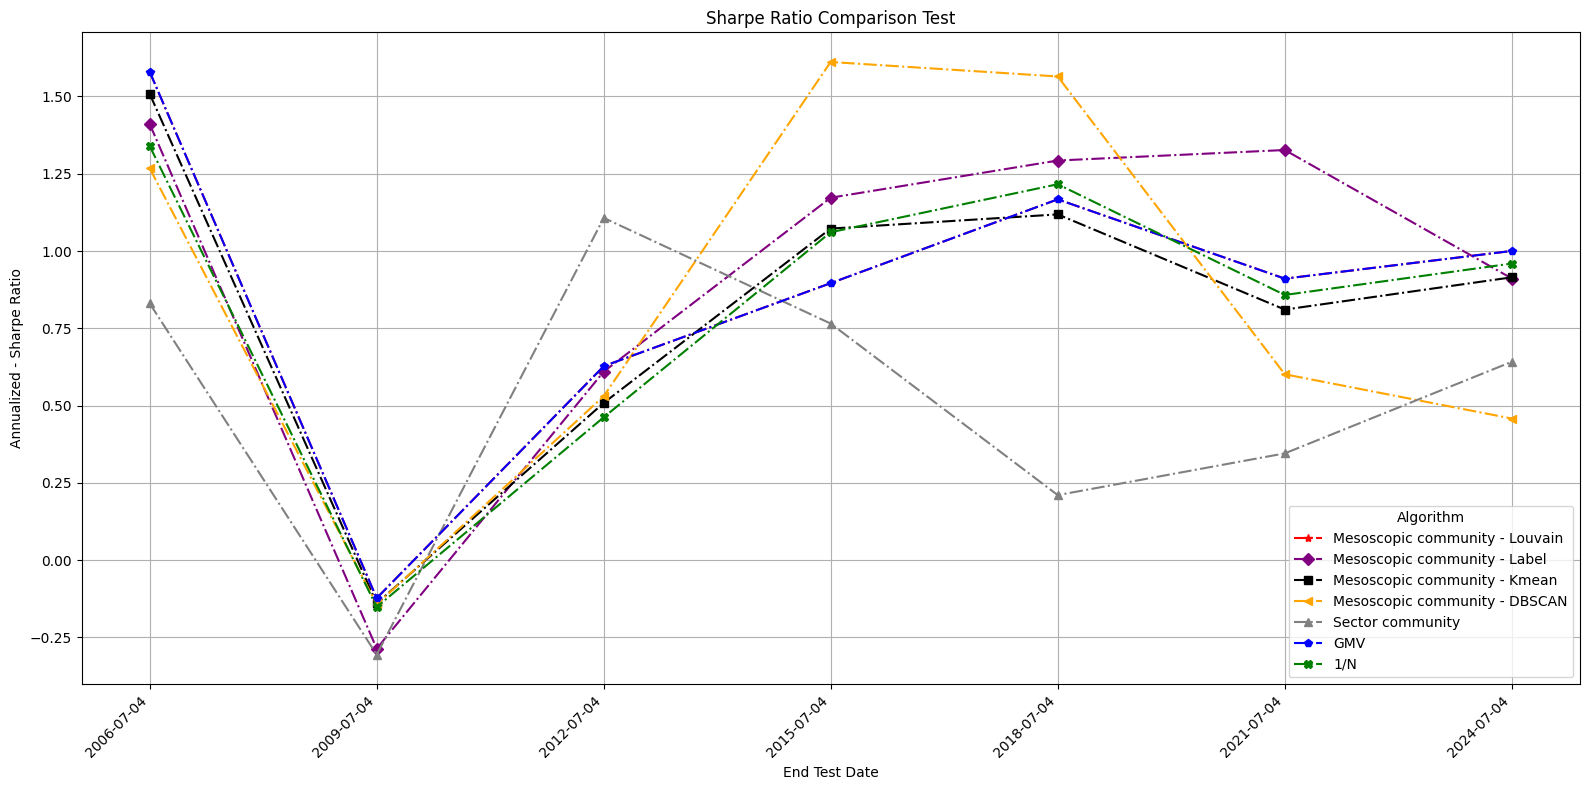

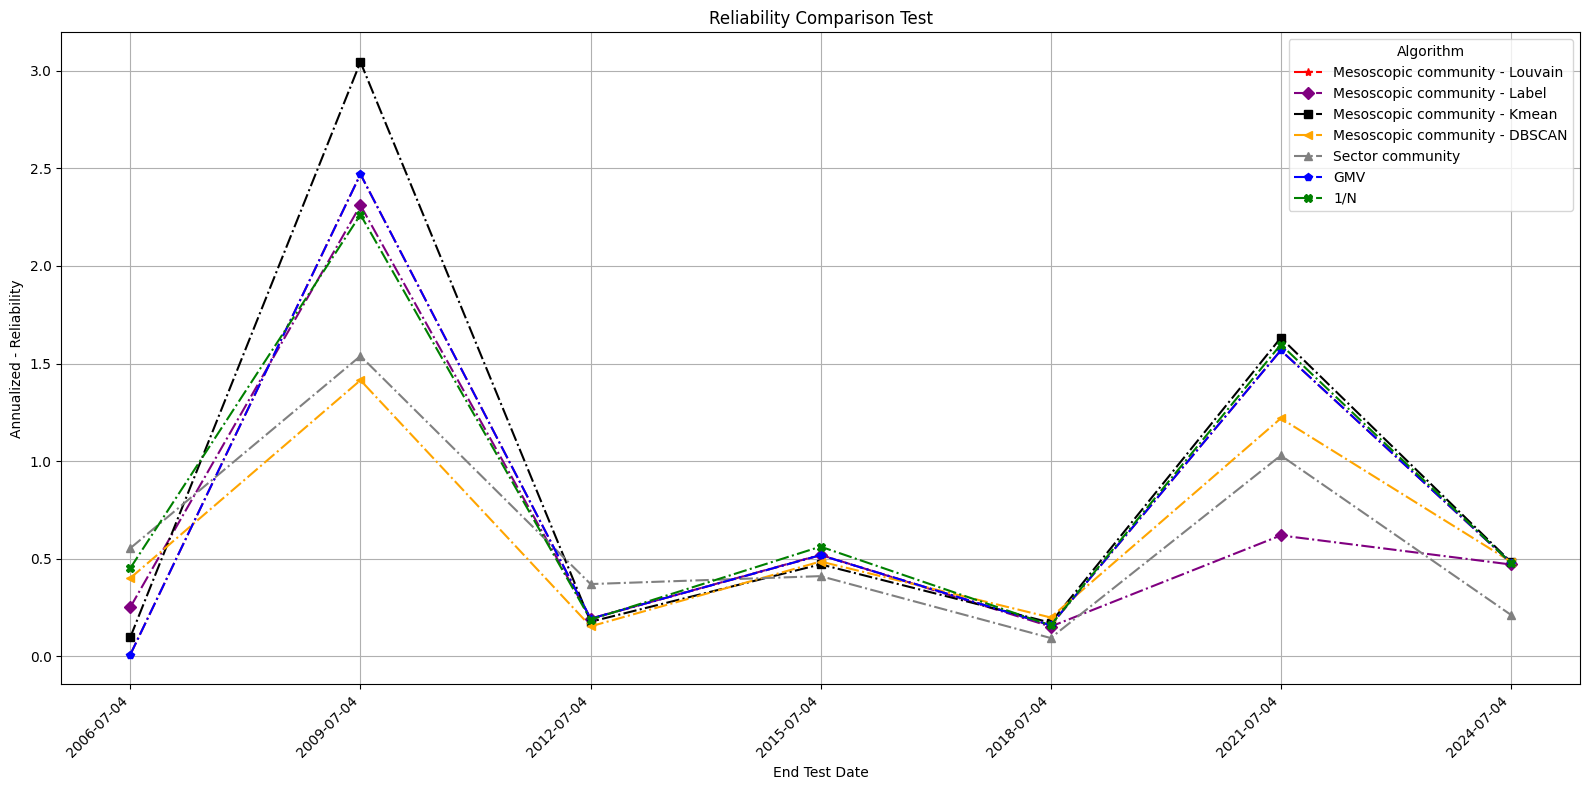

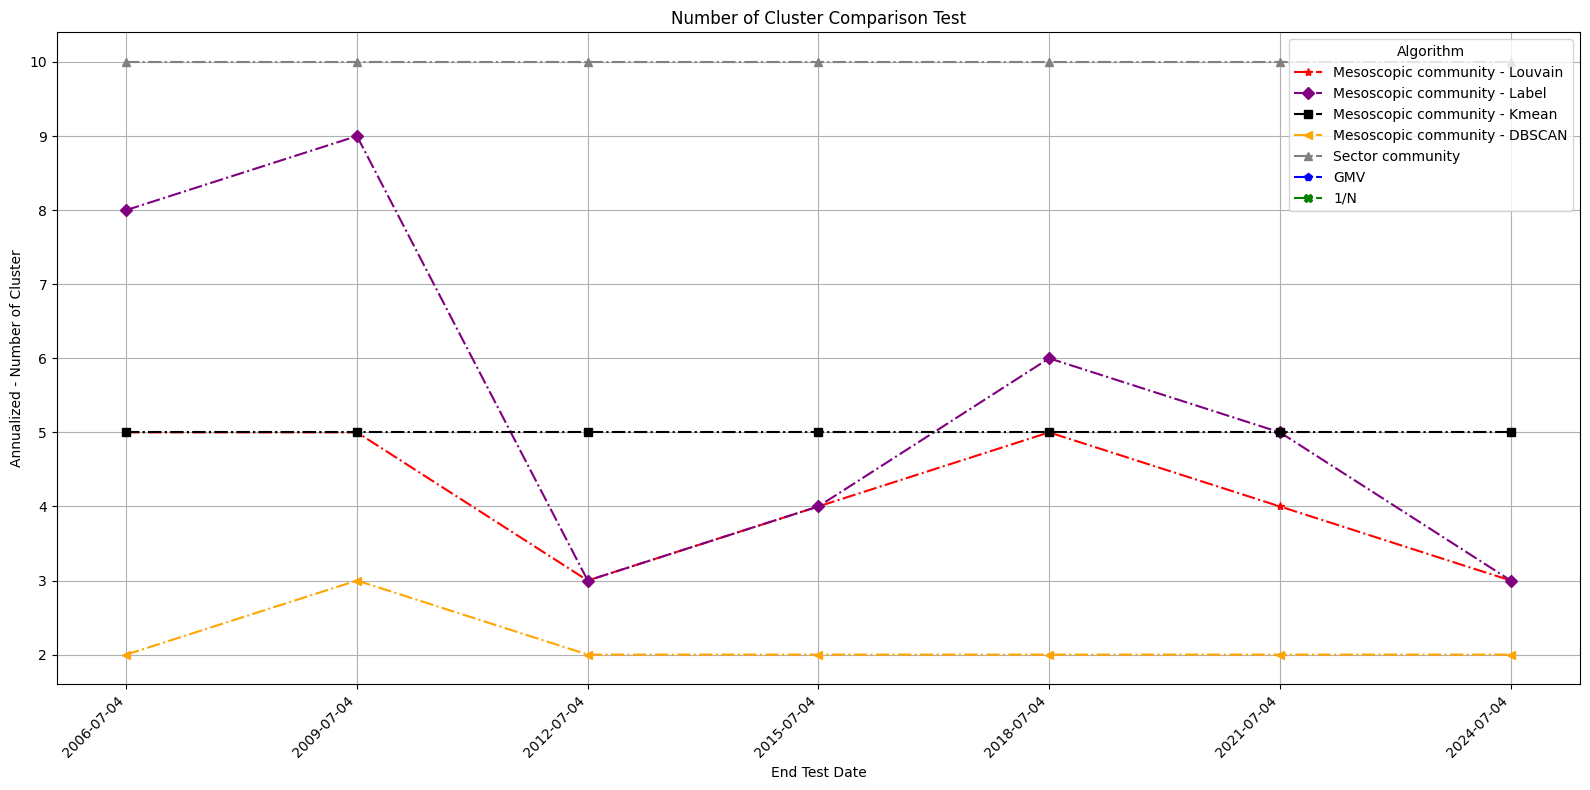

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.8656 │                0.7712 │                      4.1429 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9198 │                0.6456 │                      5.4286 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.8278 │                0.8686 │                      5      │
├────┼────────────────────────────────┼─

In [14]:
model = ["Louvain", "Label", "Kmean", "DBSCAN", "Sector","GMV", "Equal"]
results_short = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results_short[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = True, verbose = True)
method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df_short = plot_results_backtest(results_short, method_labels, markers, colors)

### Fine-Tuning

====== Start Louvain ======
Cluster found: 5
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.009389617244657922), 'Sharpe Ratio': np.float64(1.5800360667641193), 'Number of Cluster': 5}
Cluster found: 5
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.469176888270495), 'Sharpe Ratio': np.float64(-0.12272316757810023), 'Number of Cluster': 5}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.1937594918617287), 'Sharpe Ratio': np.float64(0.6277783920293531), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5186434662705658), 'Sharpe Ratio': np.float64(0.8960912849893), 'Number of Cluster': 4}
Cluster found: 5
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-07-0

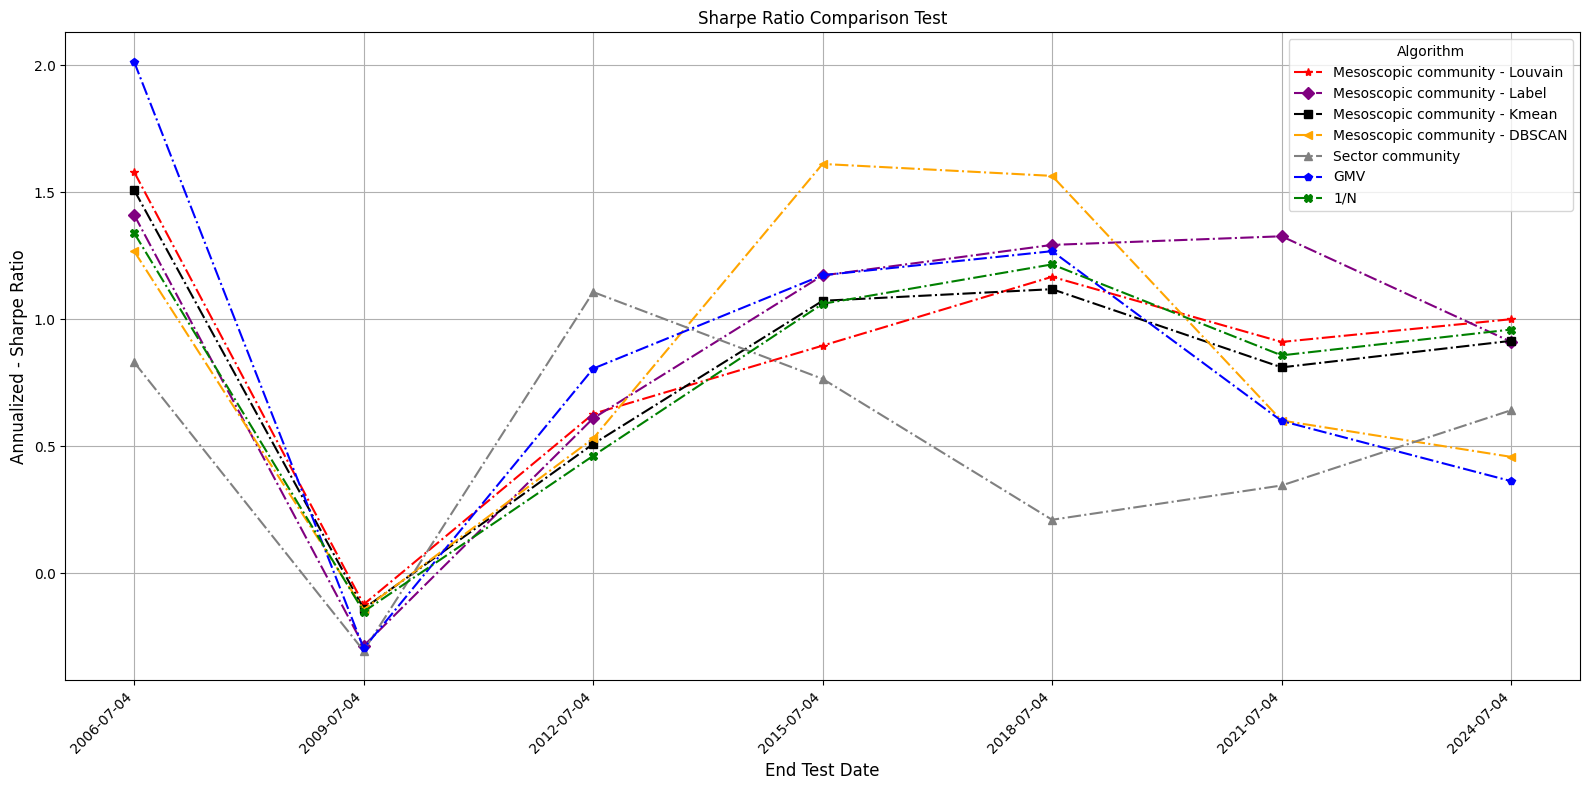

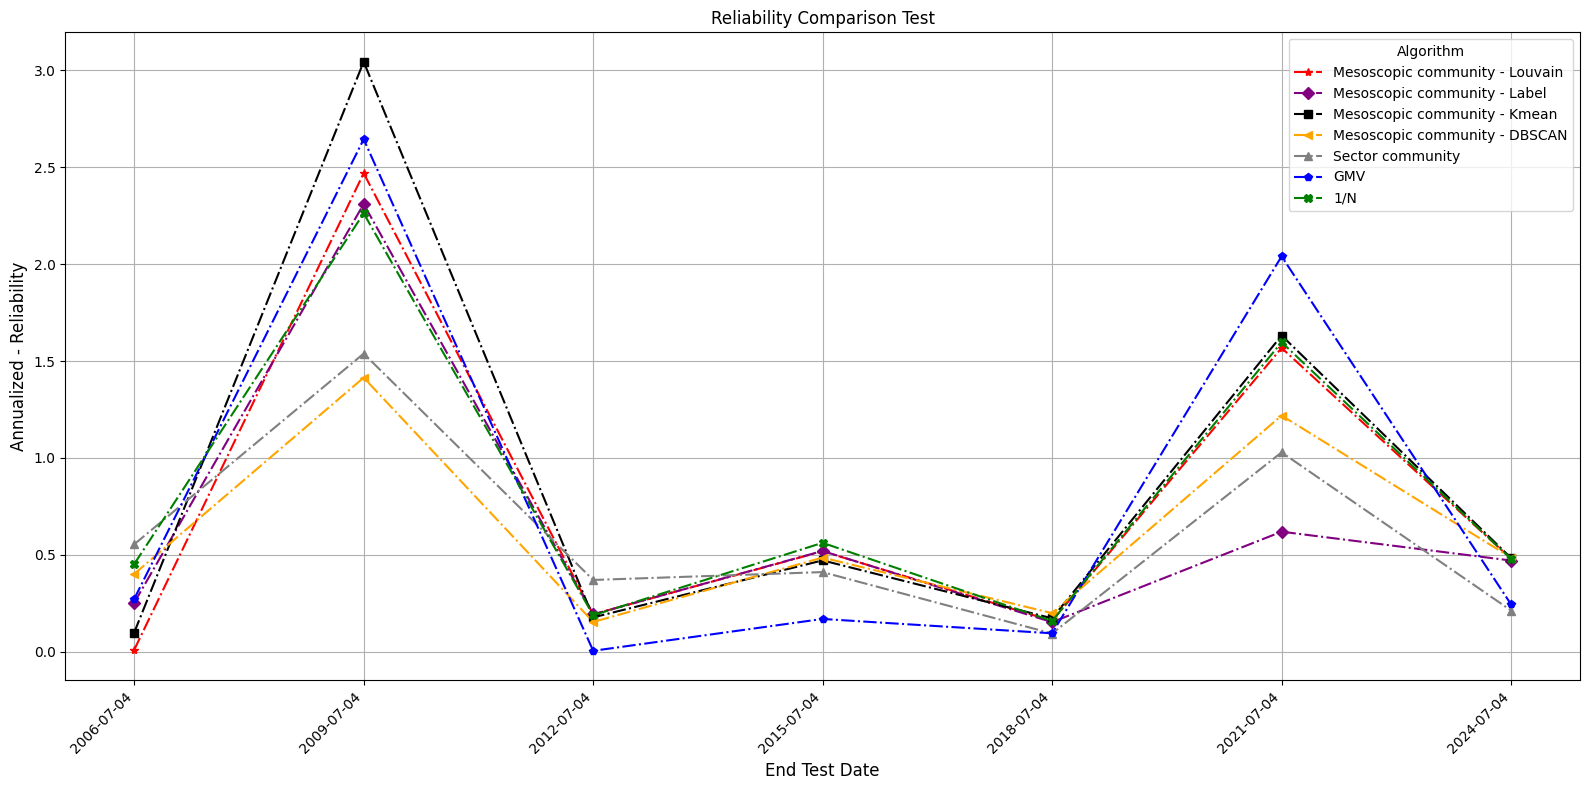

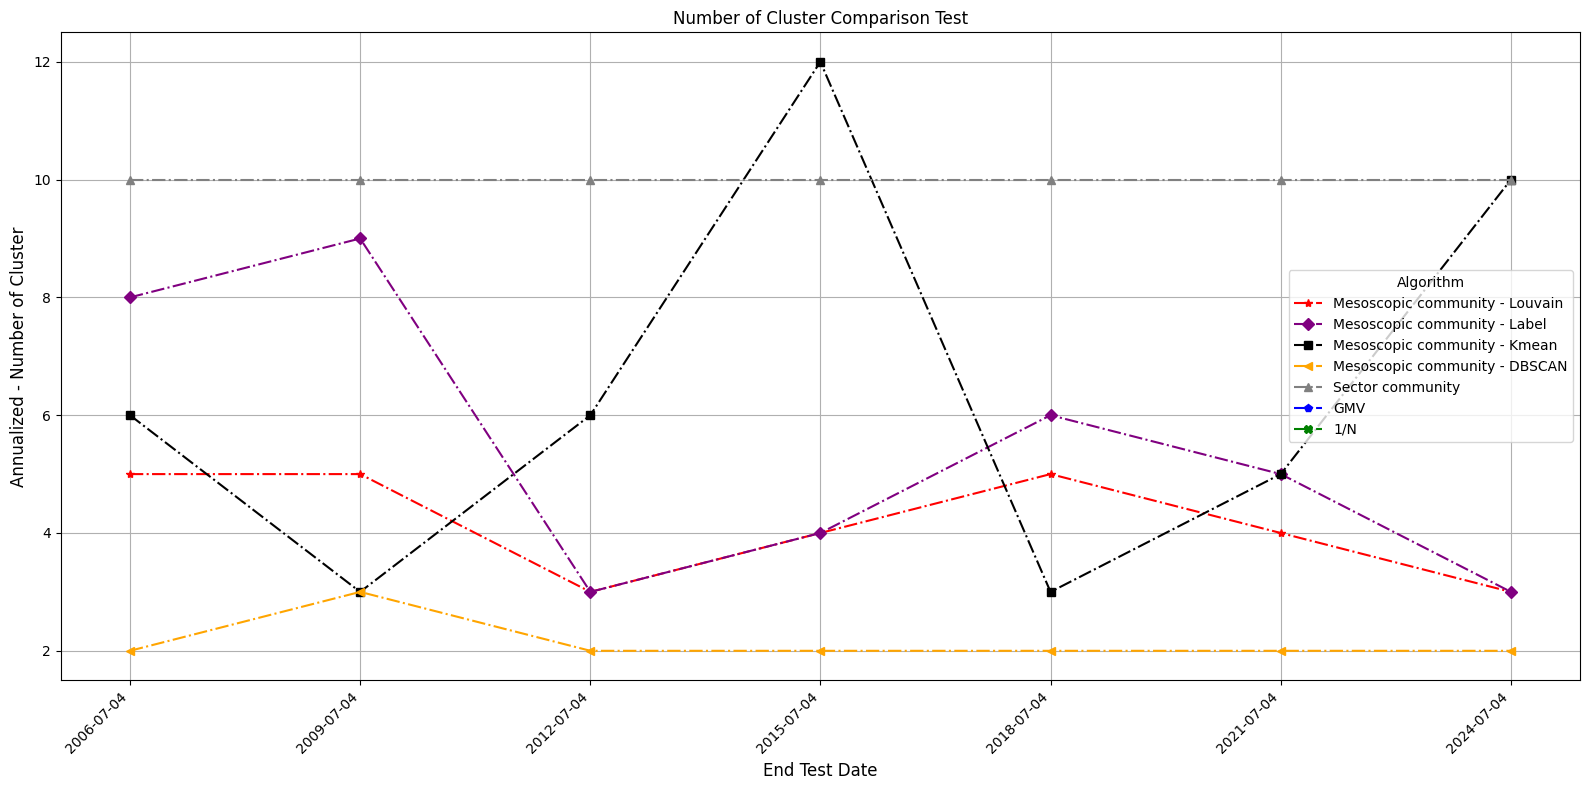

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.8656 │                0.7712 │                      4.1429 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9198 │                0.6456 │                      5.4286 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.8278 │                0.8686 │                      6.4286 │
├────┼────────────────────────────────┼─

In [18]:
model = ["Louvain", "Label","Kmean","DBSCAN", "Sector","GMV", "Equal"]
results = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = False, verbose = True, fine_tuning = True)

method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df = plot_results_backtest(results, method_labels, markers, colors)

====== Start Louvain ======
Cluster found: 5
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.009389617244657922), 'Sharpe Ratio': np.float64(1.5800360667641193), 'Number of Cluster': 5}
Cluster found: 5
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.469176888270495), 'Sharpe Ratio': np.float64(-0.12272316757810023), 'Number of Cluster': 5}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.1937594918617287), 'Sharpe Ratio': np.float64(0.6277783920293531), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5186434662705658), 'Sharpe Ratio': np.float64(0.8960912849893), 'Number of Cluster': 4}
Cluster found: 5
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-07-0

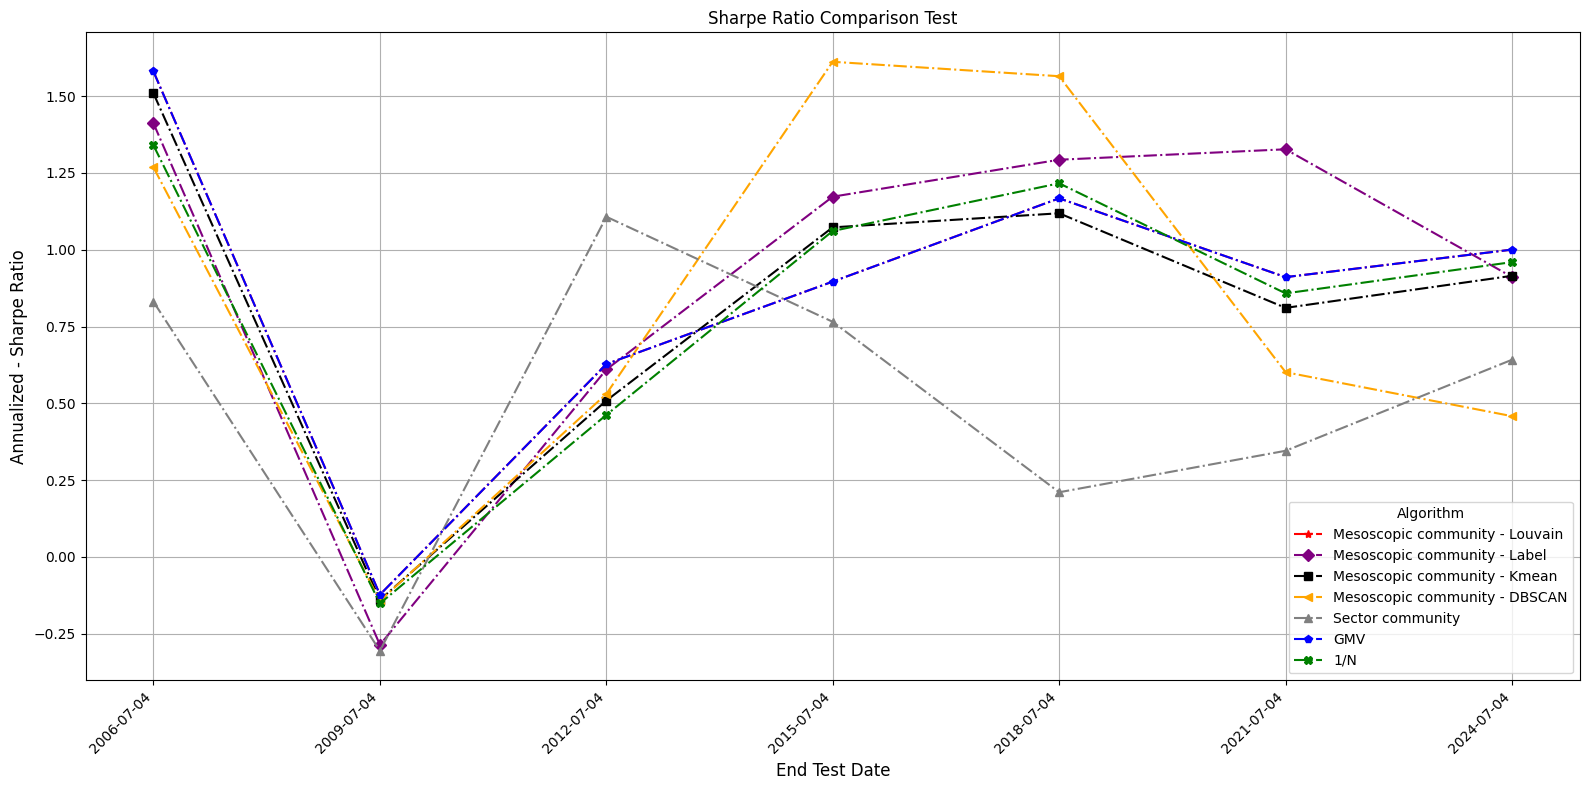

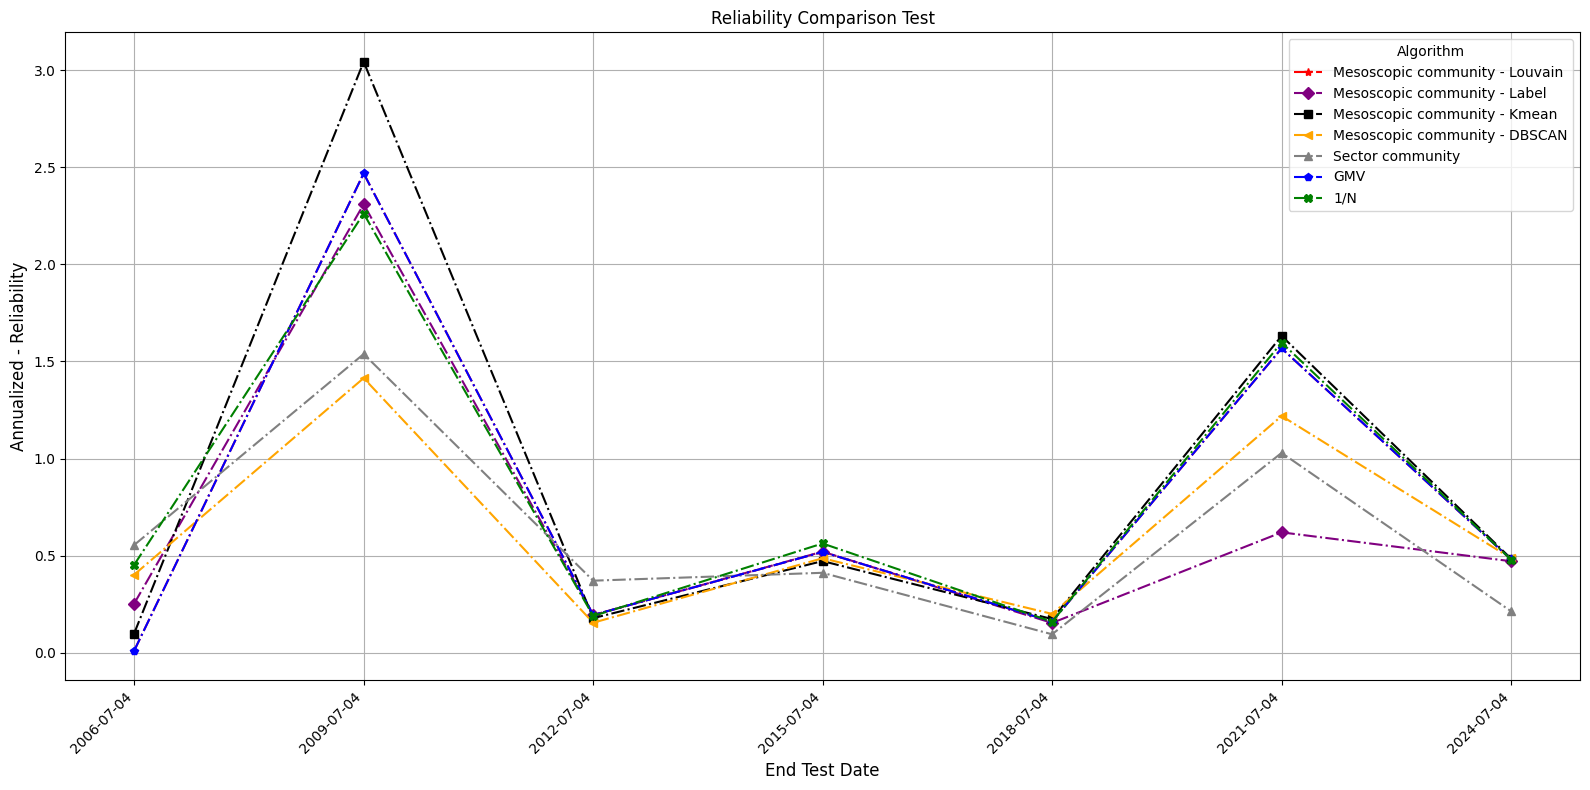

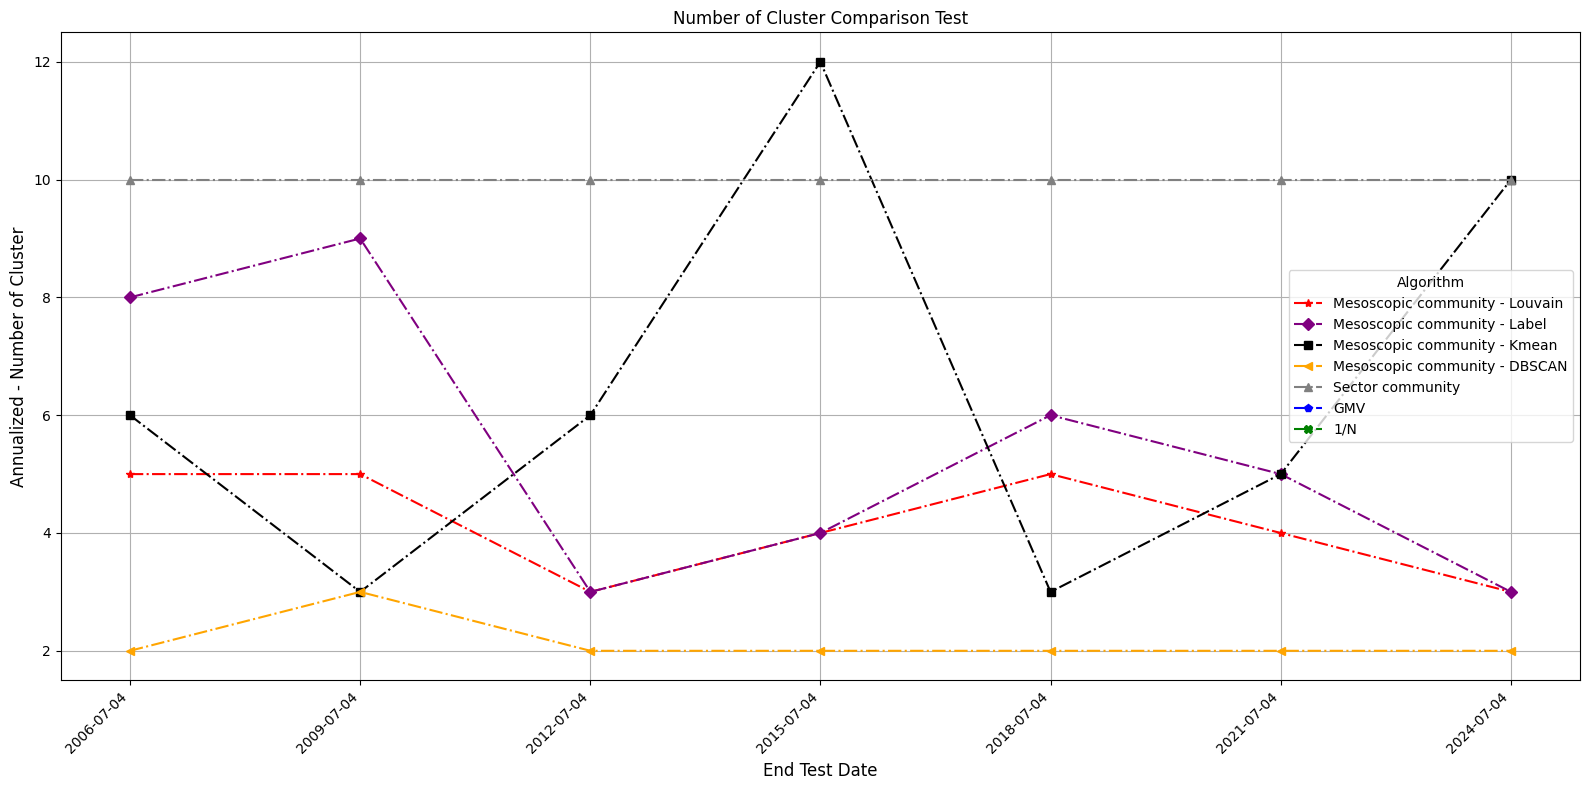

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.8656 │                0.7712 │                      4.1429 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9198 │                0.6456 │                      5.4286 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.8278 │                0.8686 │                      6.4286 │
├────┼────────────────────────────────┼─

In [19]:
model = ["Louvain", "Label", "Kmean", "DBSCAN", "Sector","GMV", "Equal"]
results_short = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results_short[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = True, verbose = True, fine_tuning = True)
method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df_short = plot_results_backtest(results_short, method_labels, markers, colors)

## Drafts

In [ ]:
def backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = 'Louvain', short = False, verbose = True):
    returns = portfolio.compute_return()
    returns.index = pd.to_datetime(returns.index)
    results = []
    start_idx = returns.index[0]
    current_date = start_idx
    while current_date + pd.DateOffset(months=train_months + burn_period_month + test_months) < returns.index[-1]:
        train_end = current_date + pd.DateOffset(months=train_months)
        test_start = train_end + pd.DateOffset(months= test_months + burn_period_month)
        test_end = test_start + pd.DateOffset(months=test_months)
        returns_train = returns[(returns.index >= current_date) & (returns.index < train_end)]
        test_data = returns[(returns.index >= test_start) & (returns.index < test_end)]
        portfolio_train = Portfolio(data_csv, price_data = price_data, returns = returns_train)
        if model == 'Louvain':
            weights = portfolio_train.portfolio_building(short = short, algo = 'Louvain')
            print(f"Cluster found: {len(np.unique(weights))}")
            num_cluster = len(np.unique(weights))
        elif model == 'Label':
            weights = portfolio_train.portfolio_building(short = short, algo = 'Label')
            print(f"Cluster found: {len(np.unique(weights))}")
            num_cluster = len(np.unique(weights))
        elif model == 'Equal':
            weights = np.ones(len(test_data.columns)) * 1 / len(test_data.columns)
            num_cluster = None
        elif model == "GMV":
            weights = portfolio_train.portfolio_building(short = short, community = short)
            num_cluster = None
        elif model == "Kmean":
            weights = portfolio_train.portfolio_building(short = short, community = True, algo = 'Kmean')
            print(f"Cluster found: {len(np.unique(weights))}")
            num_cluster = len(np.unique(weights))
        elif model == "DBSCAN":
            weights = portfolio_train.portfolio_building(short = short, community = True, algo = 'DBSCAN')
            print(f"Cluster found: {len(np.unique(weights))}")
            num_cluster = len(np.unique(weights))
        elif model == "Sector":
            weights = portfolio_train.portfolio_building(short = short, community = True, algo = 'Sector')
            print(f"Cluster found: {len(np.unique(weights))}")
            num_cluster = len(np.unique(weights))
        else:
            raise ValueError("Select a model between (Louvain, Label, Equal, GMV, Kmean, DBASCAN, Sector)")
        test_returns = test_data @ weights
        sigma_p = (portfolio_train.returns@ weights).std()
        sharpe_ann = test_returns.mean() / test_returns.std() * np.sqrt(252)
        sigma_p_ann = sigma_p * np.sqrt(252)
        sigma_test_ann = test_returns.std() * np.sqrt(252)
        results.append({
            "start": train_end,
            "end": test_end,
            "Reliability": np.abs(sigma_test_ann - sigma_p_ann)/sigma_p_ann,
            "Sharpe Ratio": sharpe_ann,
            "Number of Cluster": num_cluster
            })
        if verbose:
            print(results[-1])
        current_date = current_date + pd.DateOffset(months = train_months)
    return results


In [ ]:
portfolio = Portfolio(data_csv, price_data = price_data)
weights = portfolio.portfolio_building(short = True, community = True, algo = 'Sector')

In [ ]:
def plot_results_backtest(results, method_labels, markers,colors):
    dfs = {model: pd.DataFrame(data) for model, data in results.items()}

    for metric in ['Sharpe Ratio', 'Reliability', 'Number of Cluster']:
        fig, ax = plt.subplots(figsize=(16, 8))
        for model, df in dfs.items():
            ax.plot(
                df['end'], df[metric],
                marker=markers[model],
                linestyle='-.',
                color=colors[model],
                label=method_labels[model]
            )

        ax.set_xticks(dfs["Louvain"]['end'])
        ax.set_xticklabels(dfs["Louvain"]['end'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')
        ax.set_title(f"{metric} Comparison Test")
        ax.set_xlabel("End Test Date")
        ax.set_ylabel(f"Annualized - {metric}")
        ax.grid()
        ax.legend()
        plt.tight_layout()
        plt.show()

    # Summary Table
    summary_df = pd.DataFrame([
        {
            "Method": method_labels[model],
            "Average Sharpe Ratio ": dfs[model]['Sharpe Ratio'].mean(),
            "Average Reliability": dfs[model]['Reliability'].mean(),
            "Average Number of Cluster": dfs[model]['Number of Cluster'].mean()
        }
        for model in dfs
    ])

    print(tabulate(summary_df.round(4), headers='keys', tablefmt='fancy_grid'))
    return summary_df

In [ ]:
model = ["Louvain", "Label", "Kmean", "DBSCAN", "Sector","GMV", "Equal"]
results = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = False, verbose = True)

====== Start Louvain ======
Cluster found: 5
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.009389617244657922), 'Sharpe Ratio': np.float64(1.5800360667641193), 'Number of Cluster': 5}
Cluster found: 5
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.469176888270495), 'Sharpe Ratio': np.float64(-0.12272316757810023), 'Number of Cluster': 5}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.1937594918617287), 'Sharpe Ratio': np.float64(0.6277783920293531), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5186434662705658), 'Sharpe Ratio': np.float64(0.8960912849893), 'Number of Cluster': 4}
Cluster found: 5
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-07-0

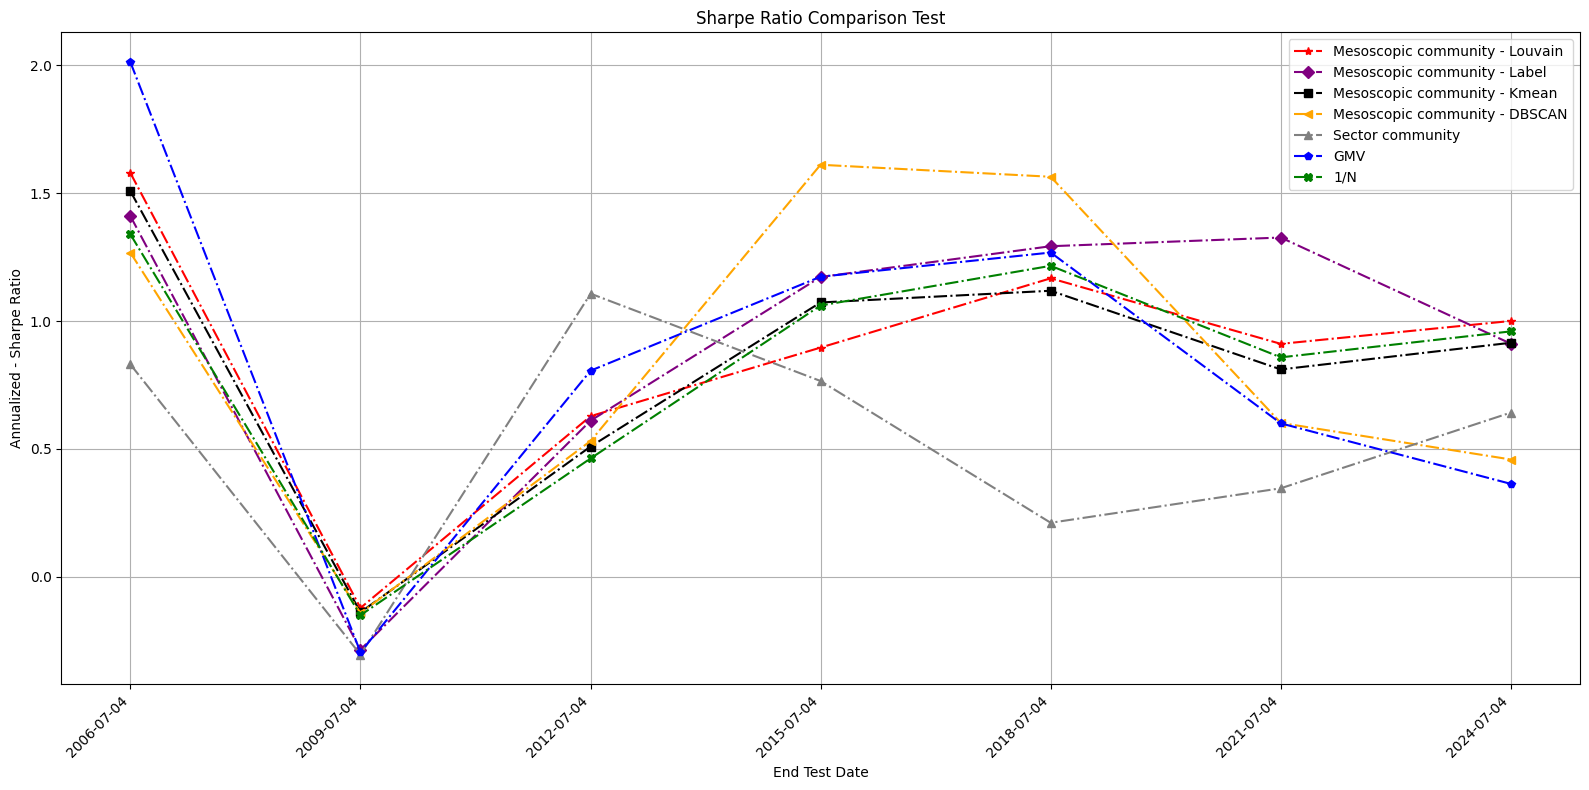

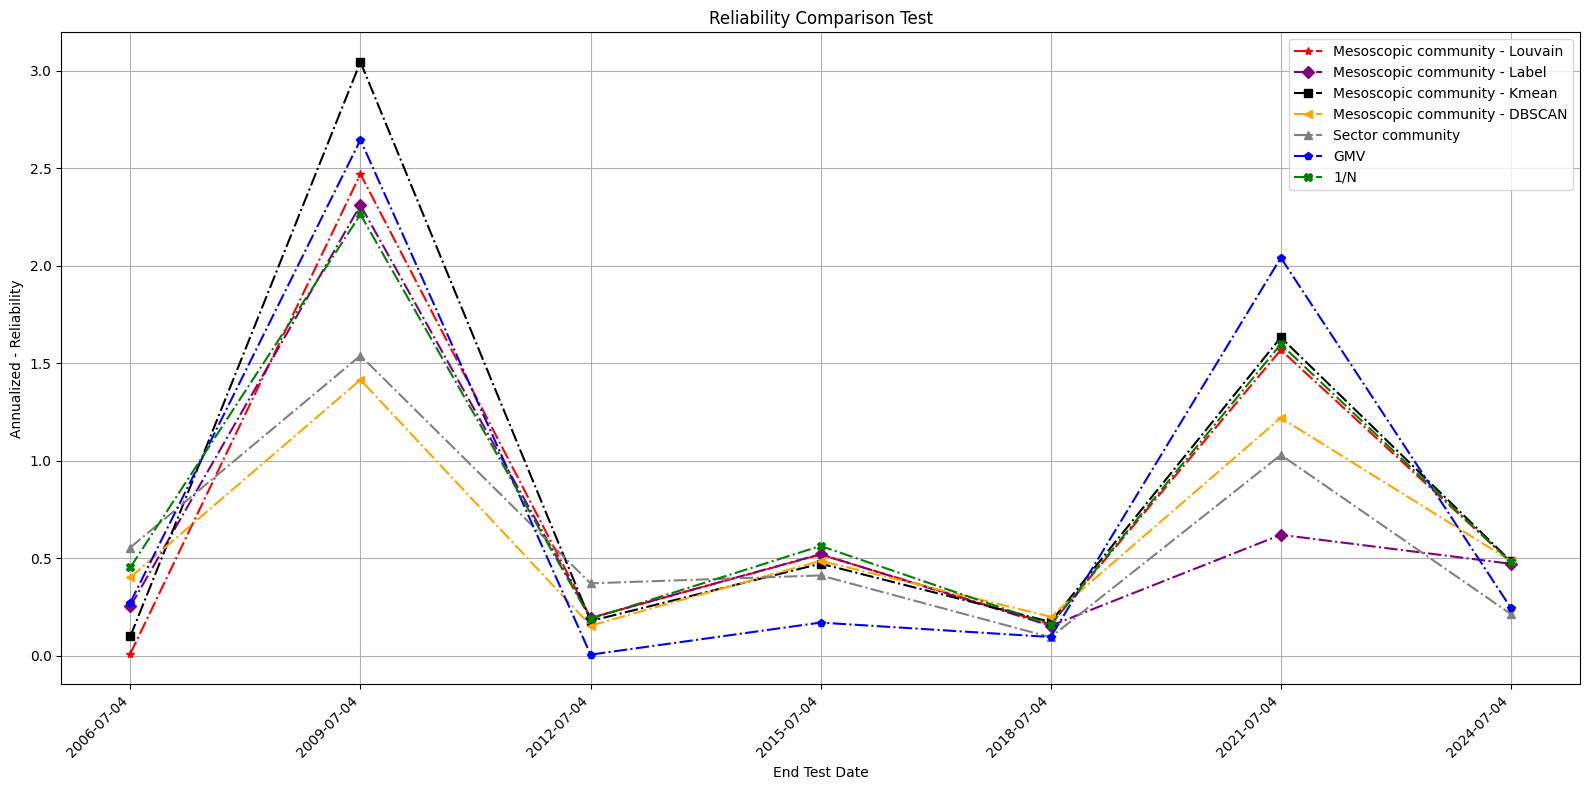

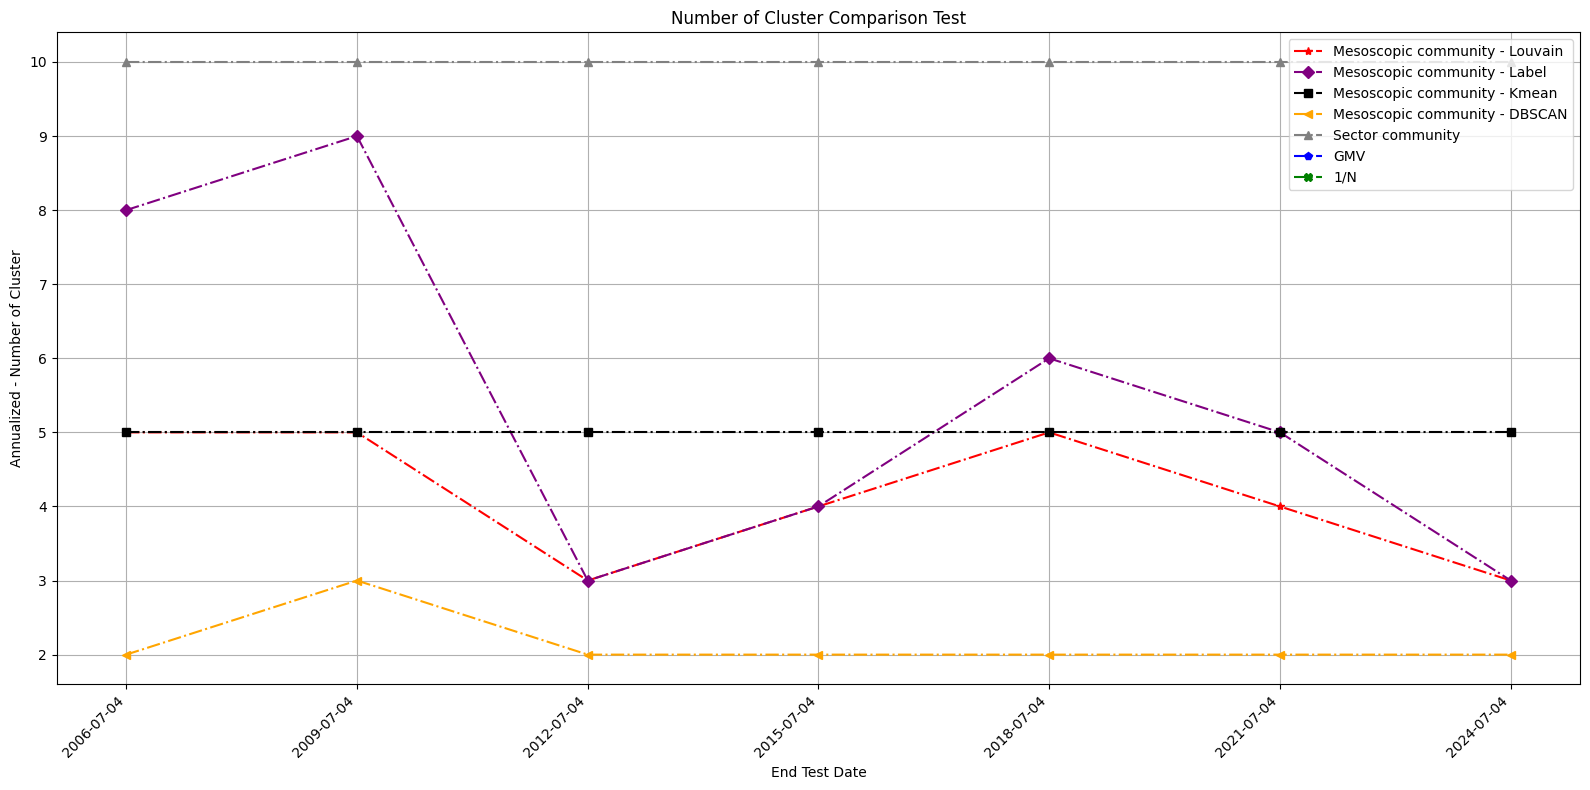

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.8656 │                0.7712 │                      4.1429 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9198 │                0.6456 │                      5.4286 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.8278 │                0.8686 │                      5      │
├────┼────────────────────────────────┼─

In [ ]:
method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df = plot_results_backtest(results, method_labels, markers, colors)


In [ ]:
model = ["Louvain", "Label", "Kmean", "DBSCAN", "Sector","GMV", "Equal"]
results_short = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results_short[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = True, verbose = True)

====== Start Louvain ======
Cluster found: 5
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.009389617244657922), 'Sharpe Ratio': np.float64(1.5800360667641193), 'Number of Cluster': 5}
Cluster found: 5
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.469176888270495), 'Sharpe Ratio': np.float64(-0.12272316757810023), 'Number of Cluster': 5}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.1937594918617287), 'Sharpe Ratio': np.float64(0.6277783920293531), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5186434662705658), 'Sharpe Ratio': np.float64(0.8960912849893), 'Number of Cluster': 4}
Cluster found: 5
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-07-0

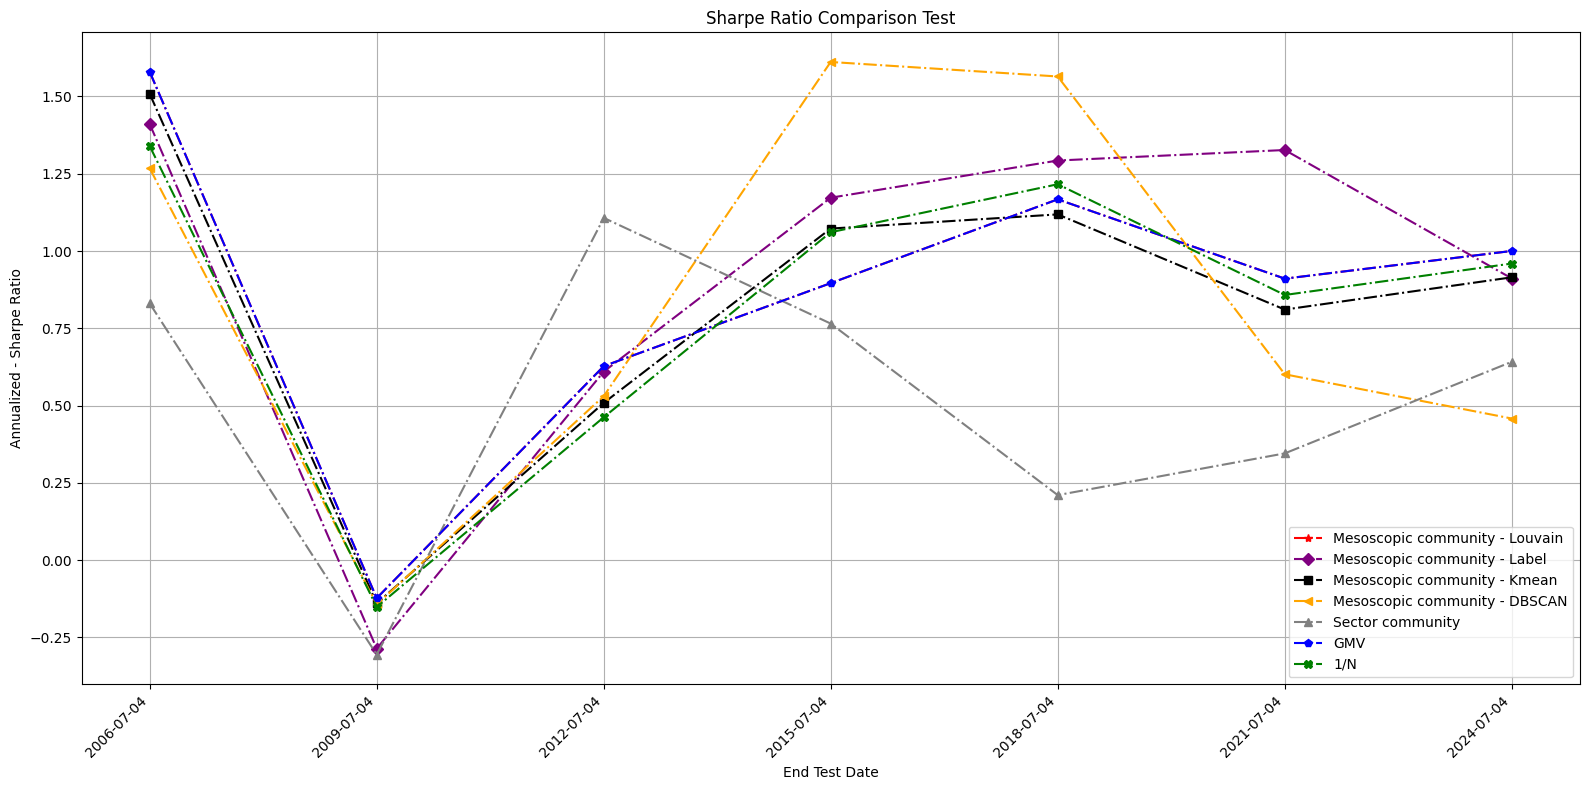

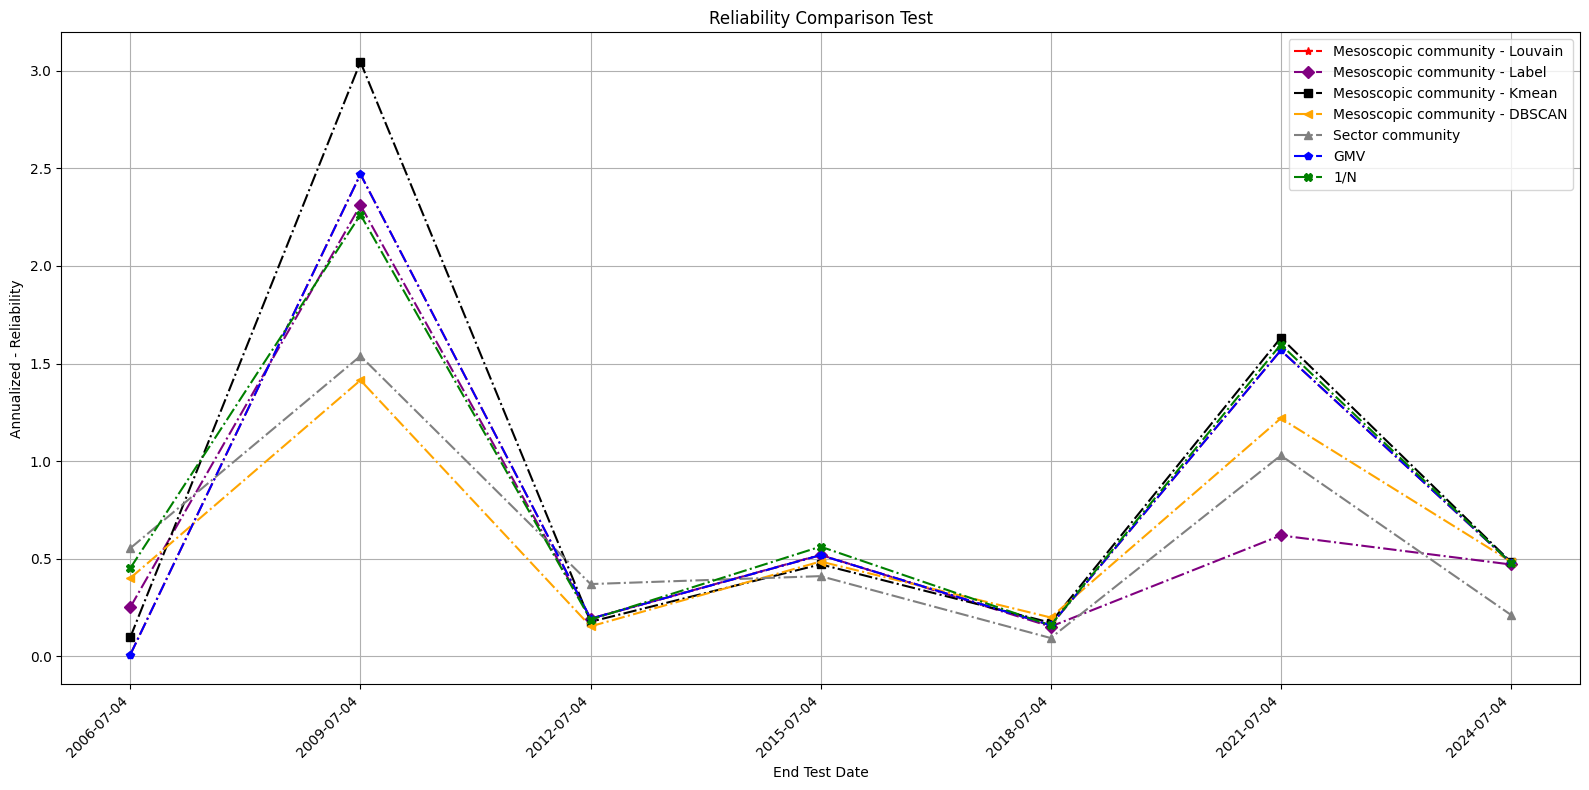

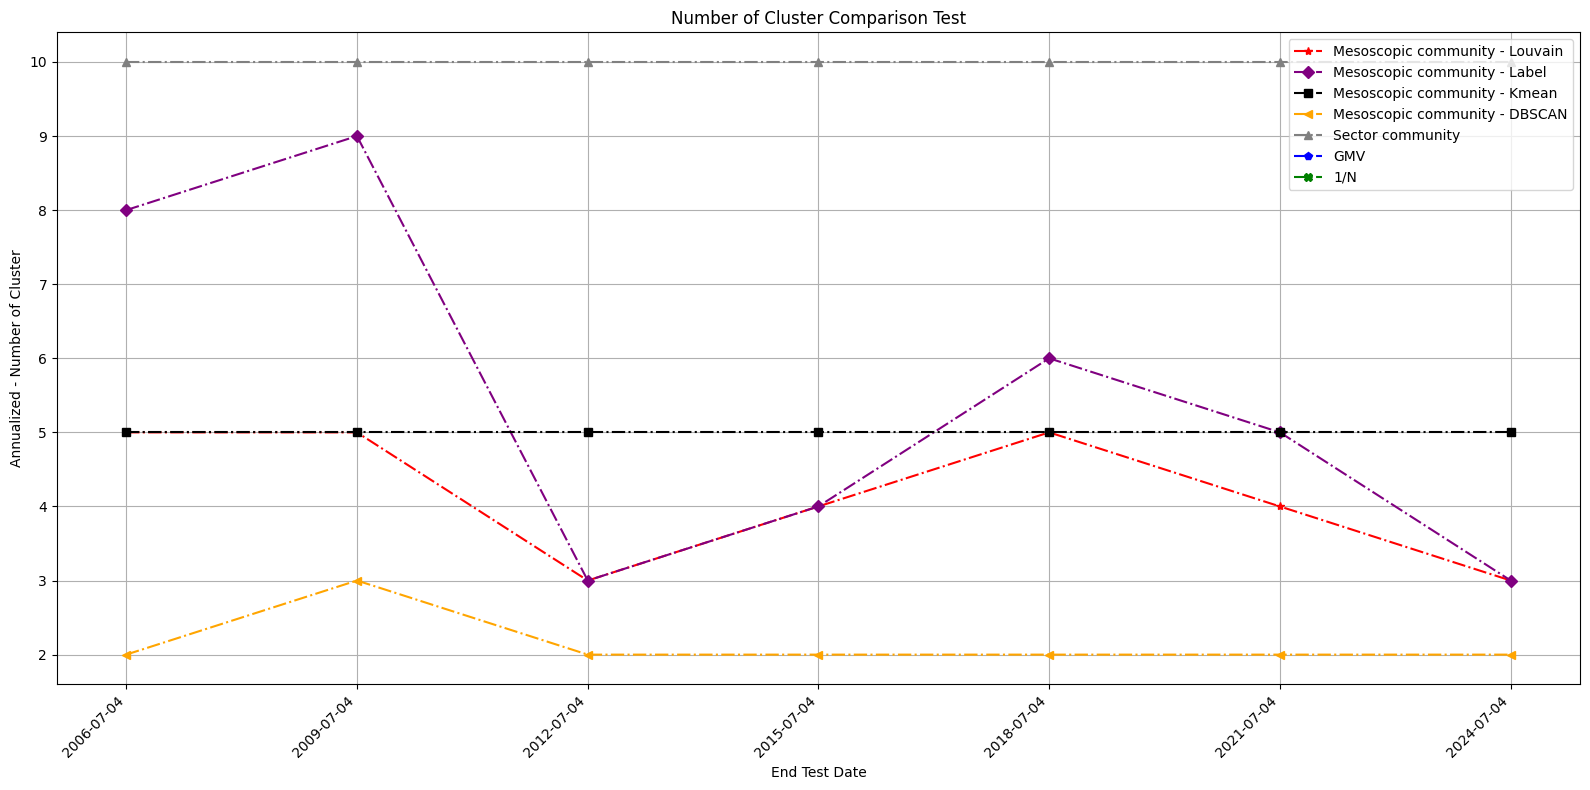

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.8656 │                0.7712 │                      4.1429 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9198 │                0.6456 │                      5.4286 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.8278 │                0.8686 │                      5      │
├────┼────────────────────────────────┼─

In [ ]:
method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df_short = plot_results_backtest(results_short, method_labels, markers, colors)